In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from py_pcha import PCHA

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu

In [2]:
def plot_pcs(res, npc, hue, palette=None):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]
        
        if palette is not None:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            hue_order=list(palette.keys()),
                            palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            # hue_order=list(palette.keys()),
                            # palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

In [3]:
outdir    = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outfigdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/"

In [4]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
adata_raw = adata_raw[adata_raw.obs['Subclass']=='L2/3']
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR','P28DR','P38NR','P38DR','P28DL'])]
counts = adata_raw.X
allgenes = adata_raw.var.index.values
adata_raw

View of AnnData object with n_obs × n_vars = 21269 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [5]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)
meta

/tmp/ipykernel_165149/12491127.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


Class_broad  Doublet  Doublet Score batch  \
AAACGCTCACTTCATT-1-P8_1a-P8   Excitatory    False       0.025713     1   
AAAGGATAGGTGCATG-1-P8_1a-P8   Excitatory    False       0.011883     1   
AAAGGGCCAGTATACC-1-P8_1a-P8   Excitatory    False       0.024667     1   
AAAGTCCCATATACCG-1-P8_1a-P8   Excitatory    False       0.027921     1   
AAAGTCCTCAGATGCT-1-P8_1a-P8   Excitatory    False       0.009527     1   
...                                  ...      ...            ...   ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a         NaN    False       0.042872    11   
TTTGGTTTCTGCCTGT-1-P38_dr_2b         NaN    False       0.007108     2   
TTTGTTGCACCGGTCA-1-P38_dr_2a         NaN    False       0.030928     2   
TTTGTTGGTGGCTAGA-1-P38_dr_2b         NaN    False       0.015884     3   
TTTGTTGTCTATTGTC-1-P38_dr_1a         NaN    False       0.028005     3   

                              leiden  n_counts  n_genes  percent_mito  \
AAACGCTCACTTCATT-1-P8_1a-P8        0   23384.0     4943      0.000128   
AAAGGATAGGTGCATG-1-P8_1a-P8        0   17774.0     4698      0.000169   
AAAGGGCCAGTATACC-1-P8_1a-P8        0   15872.0     4173      0.000126   
AAAGTCCCATATACCG-1-P8_1a-P8        0   20076.0     4761      0.000050   
AAAGTCCTCAGATGCT-1-P8_1a-P8        4   19061.0     4601      0.000000   
...                              ...       ...      ...           ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a       1   11379.0     3568      0.000879   
TTTGGTTTCTGCCTGT-1-P38_dr_2b       1   16050.0     3104      0.000062   
TTTGTTGCACCGGTCA-1-P38_dr_2a       1   13955.0     3739      0.001146   
TTTGTTGGTGGCTAGA-1-P38_dr_2b       4    7272.0     2789      0.000963   
TTTGTTGTCTATTGTC-1-P38_dr_1a       4   11447.0     2959      0.000262   

                                 sample     Type Subclass   cond easitype  \
AAACGCTCACTTCATT-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGGATAGGTGCATG-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGGGCCAGTATACC-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGTCCCATATACCG-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGTCCTCAGATGCT-1-P8_1a-P8       P8_1a  L2/3_BC     L2/3   P8NR   L2/3_C   
...                                 ...      ...      ...    ...      ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a  P38_dr_1a   L2/3_3     L2/3  P38DR   L2/3_C   
TTTGGTTTCTGCCTGT-1-P38_dr_2b  P38_dr_2b   L2/3_3     L2/3  P38DR   L2/3_C   
TTTGTTGCACCGGTCA-1-P38_dr_2a  P38_dr_2a   L2/3_3     L2/3  P38DR   L2/3_C   
TTTGTTGGTGGCTAGA-1-P38_dr_2b  P38_dr_2b   L2/3_2     L2/3  P38DR   L2/3_B   
TTTGTTGTCTATTGTC-1-P38_dr_1a  P38_dr_1a   L2/3_2     L2/3  P38DR   L2/3_B   

                              umap1  umap2 easisample easicond newtype  
AAACGCTCACTTCATT-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGGATAGGTGCATG-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGGGCCAGTATACC-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGTCCCATATACCG-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGTCCTCAGATGCT-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_C  
...                             ...    ...        ...      ...     ...  
TTTGGTTCAGTTGTTG-1-P38_dr_1a    NaN    NaN         1a  2-P38DR  L2/3_B  
TTTGGTTTCTGCCTGT-1-P38_dr_2b    NaN    NaN         2b  2-P38DR  L2/3_B  
TTTGTTGCACCGGTCA-1-P38_dr_2a    NaN    NaN         2a  2-P38DR  L2/3_B  
TTTGTTGGTGGCTAGA-1-P38_dr_2b    NaN    NaN         2b  2-P38DR  L2/3_A  
TTTGTTGTCTATTGTC-1-P38_dr_1a    NaN    NaN         1a  2-P38DR  L2/3_B  

[41048 rows x 18 columns]

In [6]:
# update new type 
adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()
adata_raw.obs.update(meta[['newtype']])

/tmp/ipykernel_165149/3478751590.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()


In [7]:
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
newtypes = adata_raw.obs['newtype'].values
samps = adata_raw.obs['sample'].values

rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}

def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

In [8]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [9]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [10]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

In [11]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# mean
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))

# organize
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)
assert np.all(gsel_idx != -1)

In [12]:
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(l23_gidx != -1)

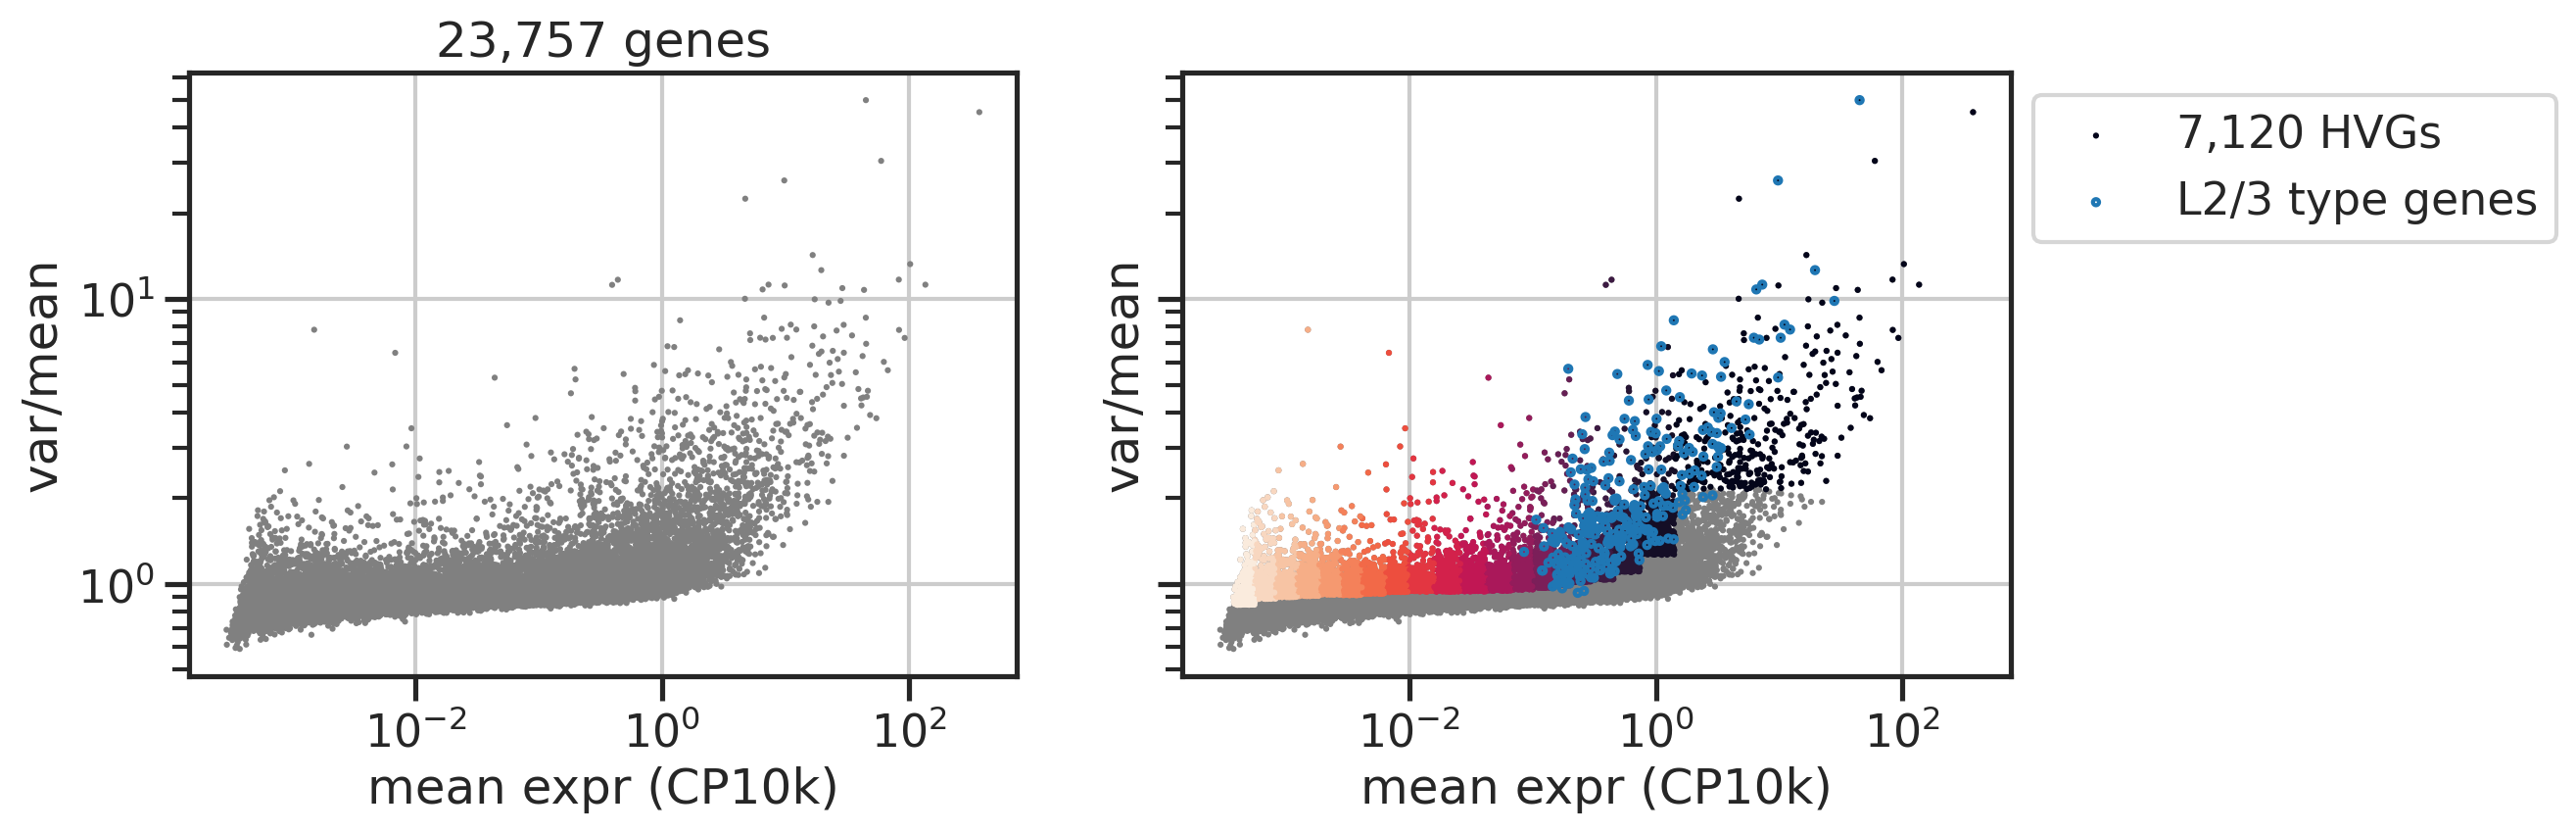

In [13]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.set_title(f'{len(gm):,} genes')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='rocket_r', label=f'{len(gsel_idx):,} HVGs')
ax.scatter(gm[l23_gidx], (gv/gm)[l23_gidx], s=5, facecolors='none', edgecolor='C0', label='L2/3 type genes')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [14]:
# adata = adata_sub[:,gsel_idx]
adata = adata_sub[:,l23_gidx]
genes_sel = adata.var.index.values
adata

View of AnnData object with n_obs × n_vars = 21269 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
    layers: 'norm', 'lognorm'

In [15]:
def pca_pipe(adata):
    
    np.random.seed(0)
    pca = PCA(n_components=4)
    
    zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    zlognorm = np.nan_to_num(zlognorm, 0)
    
    pcs = pca.fit_transform(zlognorm) # auto centering
    
    return zlognorm-np.mean(zlognorm, axis=0), pca, pcs # manual centering

In [16]:
np.random.seed(0)

X, pca, pcs = pca_pipe(adata)
V = pca.components_.T
V[:,1] = -V[:,1]
pcs[:,1] = -pcs[:,1]

In [17]:
adata.obsm['pcs'] = pcs

In [18]:
adata_nr28 = adata[adata.obs['cond']=='P28NR']
adata_dr28 = adata[adata.obs['cond']=='P28DR']

adata_nr38 = adata[adata.obs['cond']=='P38NR']
adata_dr38 = adata[adata.obs['cond']=='P38DR']

adata_dl28 = adata[adata.obs['cond']=='P28DL']

In [19]:
adata_nr28_1 = adata[adata.obs['sample'].apply(lambda x: 'P28_1' in x)]
adata_nr28_2 = adata[adata.obs['sample'].apply(lambda x: 'P28_2' in x)]

adata_nr38_1 = adata[adata.obs['sample'].apply(lambda x: 'P38_1' in x)]
adata_nr38_2 = adata[adata.obs['sample'].apply(lambda x: 'P38_2' in x)]

adata_nr = adata[adata.obs['cond'].isin(['P28NR', 'P38NR'])]
adata_dr = adata[adata.obs['cond'].isin(['P28DR', 'P38DR'])]
adata_nr38_1.shape, adata_nr38_2.shape

((720, 286), (1977, 286))

In [20]:
def organize_pc_res(adata, pcs):
    """
    """
    df = adata.obs.join(pd.DataFrame(pcs, 
                                     index=adata.obs.index, 
                                     columns=np.char.add("PC", (1+np.arange(pcs.shape[1])).astype(str))))
    return df

In [21]:
df_nr28 = organize_pc_res(adata_nr28, adata_nr28.obsm['pcs'])
df_dr28 = organize_pc_res(adata_dr28, adata_dr28.obsm['pcs'])
df_dl28 = organize_pc_res(adata_dl28, adata_dl28.obsm['pcs'])

df_nr38 = organize_pc_res(adata_nr38, adata_nr38.obsm['pcs'])
df_dr38 = organize_pc_res(adata_dr38, adata_dr38.obsm['pcs'])

df_nr = organize_pc_res(adata_nr, adata_nr.obsm['pcs'])
df_dr = organize_pc_res(adata_dr, adata_dr.obsm['pcs'])

In [22]:
prj_nr28 = adata_nr28.obsm['pcs'][:,:2]
prj_dr28 = adata_dr28.obsm['pcs'][:,:2]
prj_dl28 = adata_dl28.obsm['pcs'][:,:2]

prj_nr38 = adata_nr38.obsm['pcs'][:,:2]
prj_dr38 = adata_dr38.obsm['pcs'][:,:2]

prj_nr = adata_nr.obsm['pcs'][:,:2]
prj_dr = adata_dr.obsm['pcs'][:,:2]

In [23]:
labels = ['P28NR', 'P28DR', 'P28DL', 'P38NR', 'P38DR',]
prjs = [prj_nr28, prj_dr28, prj_dl28, prj_nr38, prj_dr38,]
dfs = [df_nr28, df_dr28, df_dl28, df_nr38, df_dr38]


labels2 = ['NR', 'DR',]
prjs2 = [prj_nr, prj_dr]
dfs2 = [df_nr, df_dr]

In [24]:
palette_type = collections.OrderedDict({
    "L2/3_A": "C0",
    "L2/3_B": "C1",
    "L2/3_C": "C2",
})
palette_type_list = [c for i, c in palette_type.items()]

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_scatter_2023-11-20.pdf


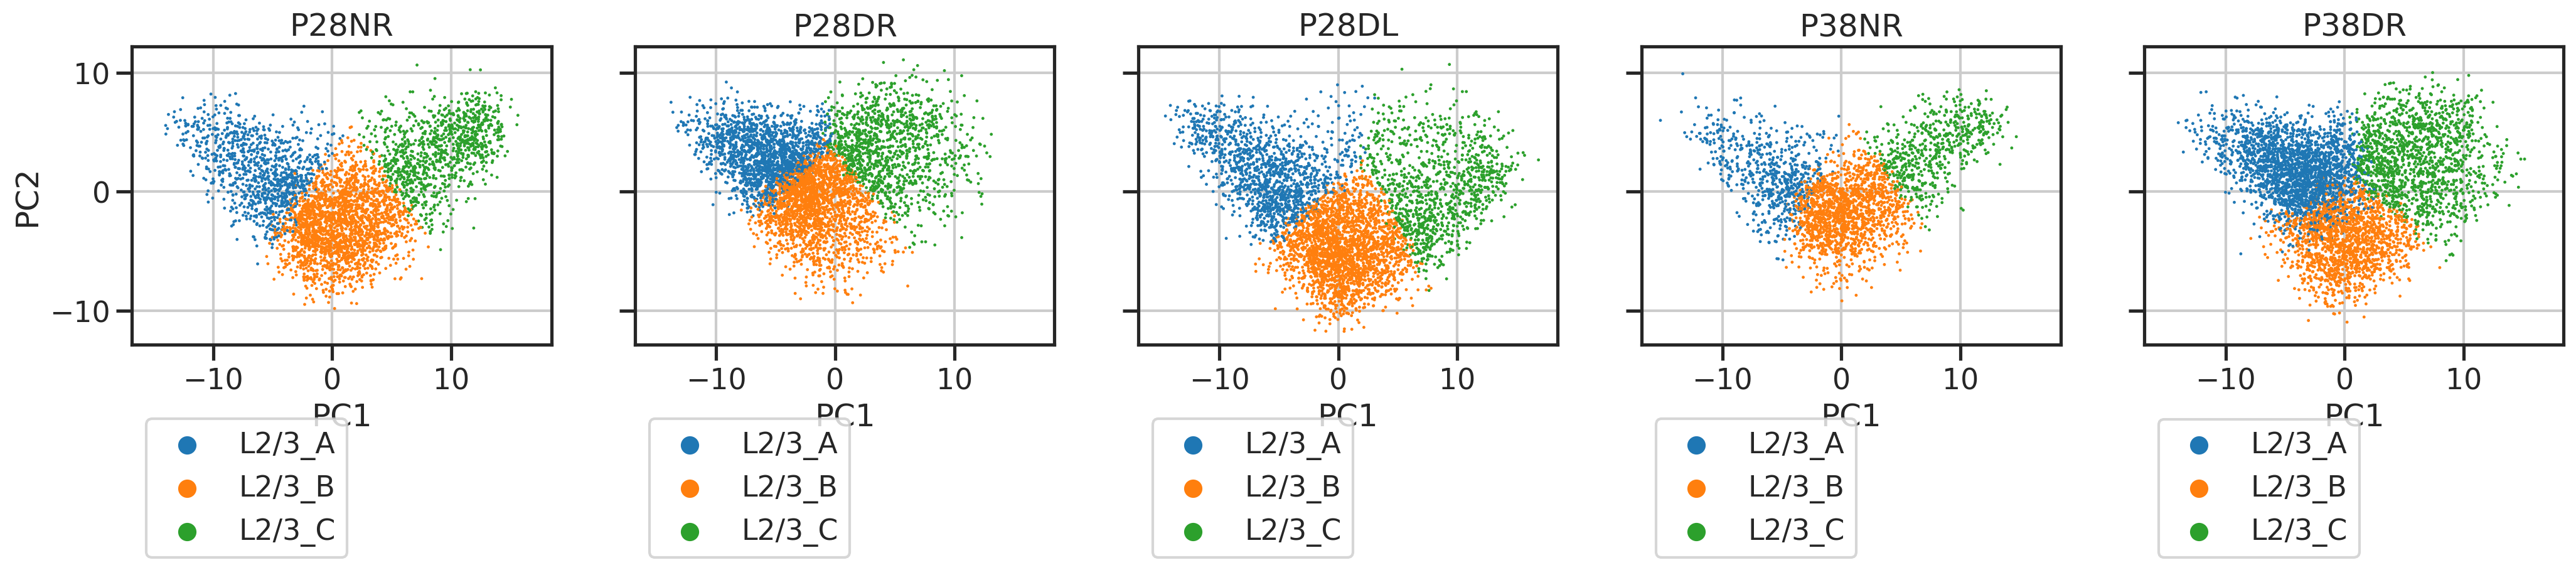

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), 
                    rasterized=True,
                    ax=ax)
    ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')

output = os.path.join(outfigdir, 'grad_scatter.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_scatter2_2023-11-20.pdf


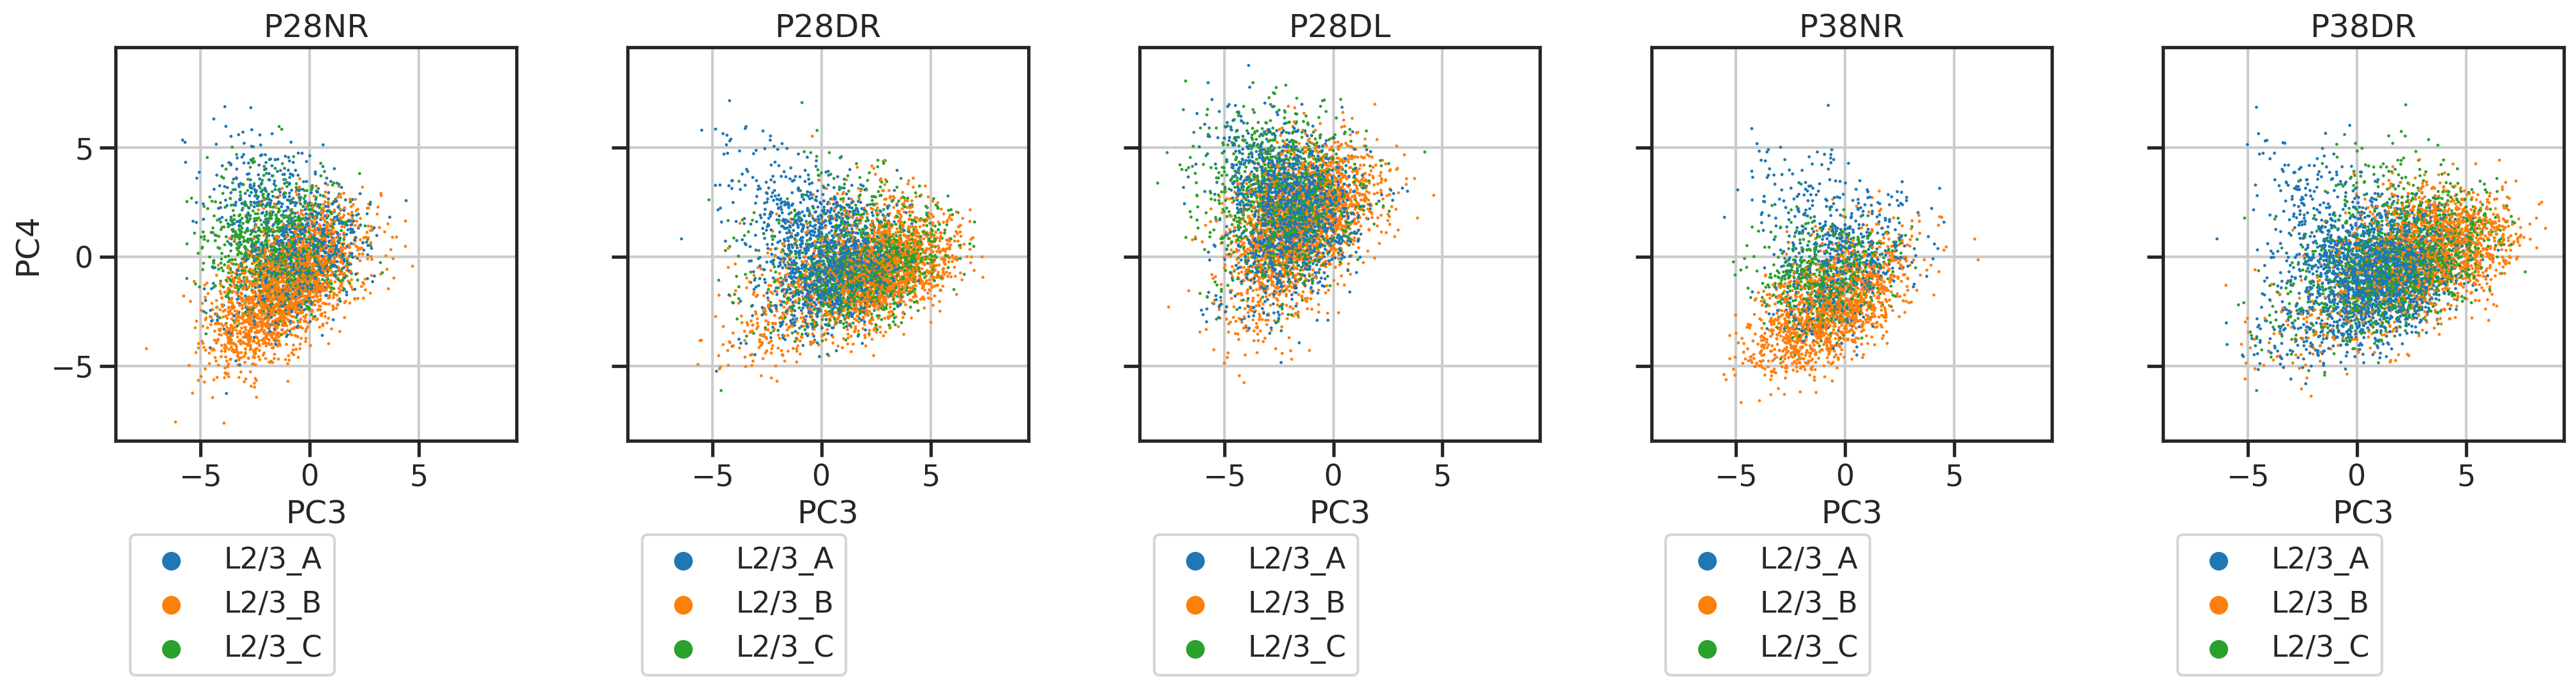

In [26]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.scatterplot(data=df, x='PC3', y='PC4', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), 
                    rasterized=True,
                    ax=ax)
    ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')

output = os.path.join(outfigdir, 'grad_scatter2.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_heatmap_2023-11-20.pdf


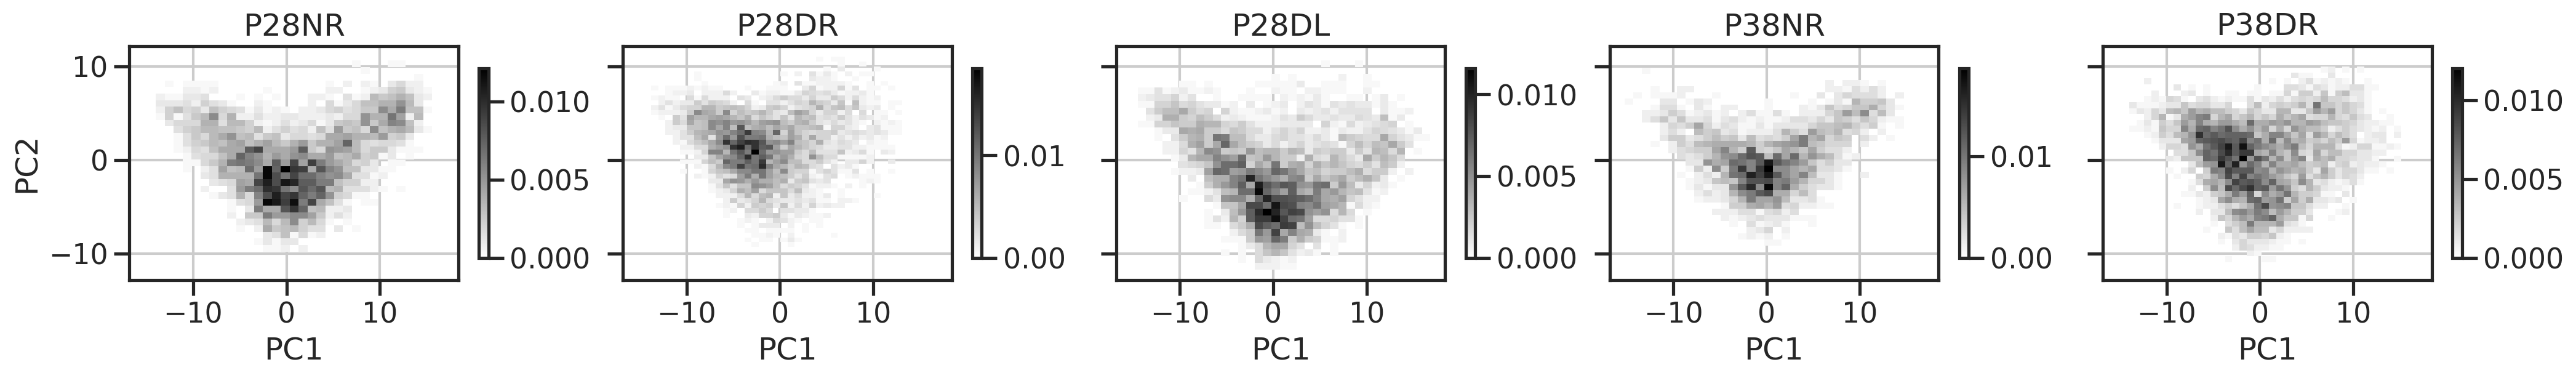

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.histplot(ax=ax, data=df, stat='density', x='PC1', y='PC2', cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    # ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')
output = os.path.join(outfigdir, 'grad_heatmap.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

# Archetype

In [28]:
from py_pcha import PCHA

In [29]:
def get_dists_to_specialists(prj, XC):
    """
    """
    diffs = np.array([prj-XC[:,0], prj-XC[:,1], prj-XC[:,2]]) # specialist by cell by dim
    dists = np.sqrt(np.sum(np.power(diffs, 2), axis=2)) # specialist by cell
    # print(diffs.shape, dists.shape)
    return dists

In [30]:
np.random.seed(0)
XC_dict = {}
for lbl, prj in zip(labels, prjs): 
    X = prj.T
    XC, S, C, SSE, varexpl = PCHA(X, noc=3, delta=0)
    XC = np.array(XC)
    XC = XC[:,np.argsort(XC[0])].copy() # order this
    print(XC.shape, S.shape, C.shape, SSE.shape, varexpl.shape, SSE, varexpl)
    XC_dict[lbl] = XC

(2, 3) (3, 4044) (4044, 3) () () 477.86512949864846 0.997641935290056
(2, 3) (3, 4704) (4704, 3) () () 903.2873654970026 0.9949758242932409
(2, 3) (3, 4659) (4659, 3) () () 899.3951732160058 0.9964083083345829
(2, 3) (3, 2697) (2697, 3) () () 149.9616779935168 0.9985678536486335
(2, 3) (3, 5165) (5165, 3) () () 1111.605222069542 0.9946481610126631


In [31]:
XC_dict2 = {}
for lbl, prj in zip(labels2, prjs2): 
    X = prj.T
    XC, S, C, SSE, varexpl = PCHA(X, noc=3, delta=0)
    XC = np.array(XC)
    XC = XC[:,np.argsort(XC[0])].copy() # order this
    print(XC.shape, S.shape, C.shape, SSE.shape, varexpl.shape, SSE, varexpl)
    XC_dict2[lbl] = XC

(2, 3) (3, 6741) (6741, 3) () () 512.8001396161853 0.9983316115813025
(2, 3) (3, 9869) (9869, 3) () () 1719.5862493270542 0.9955622829113666


In [32]:
dists_dict = {}
for lbl, prj in zip(labels, prjs): 
    XC  = XC_dict[lbl]
    dists = get_dists_to_specialists(prj, XC)
    dists_dict[lbl] = dists

In [33]:
dists_dict2 = {}
for lbl, prj in zip(labels, prjs): 
    XC  = XC_dict['P28NR']
    dists = get_dists_to_specialists(prj, XC)
    dists_dict2[lbl] = dists

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_archetype_2023-11-20.pdf


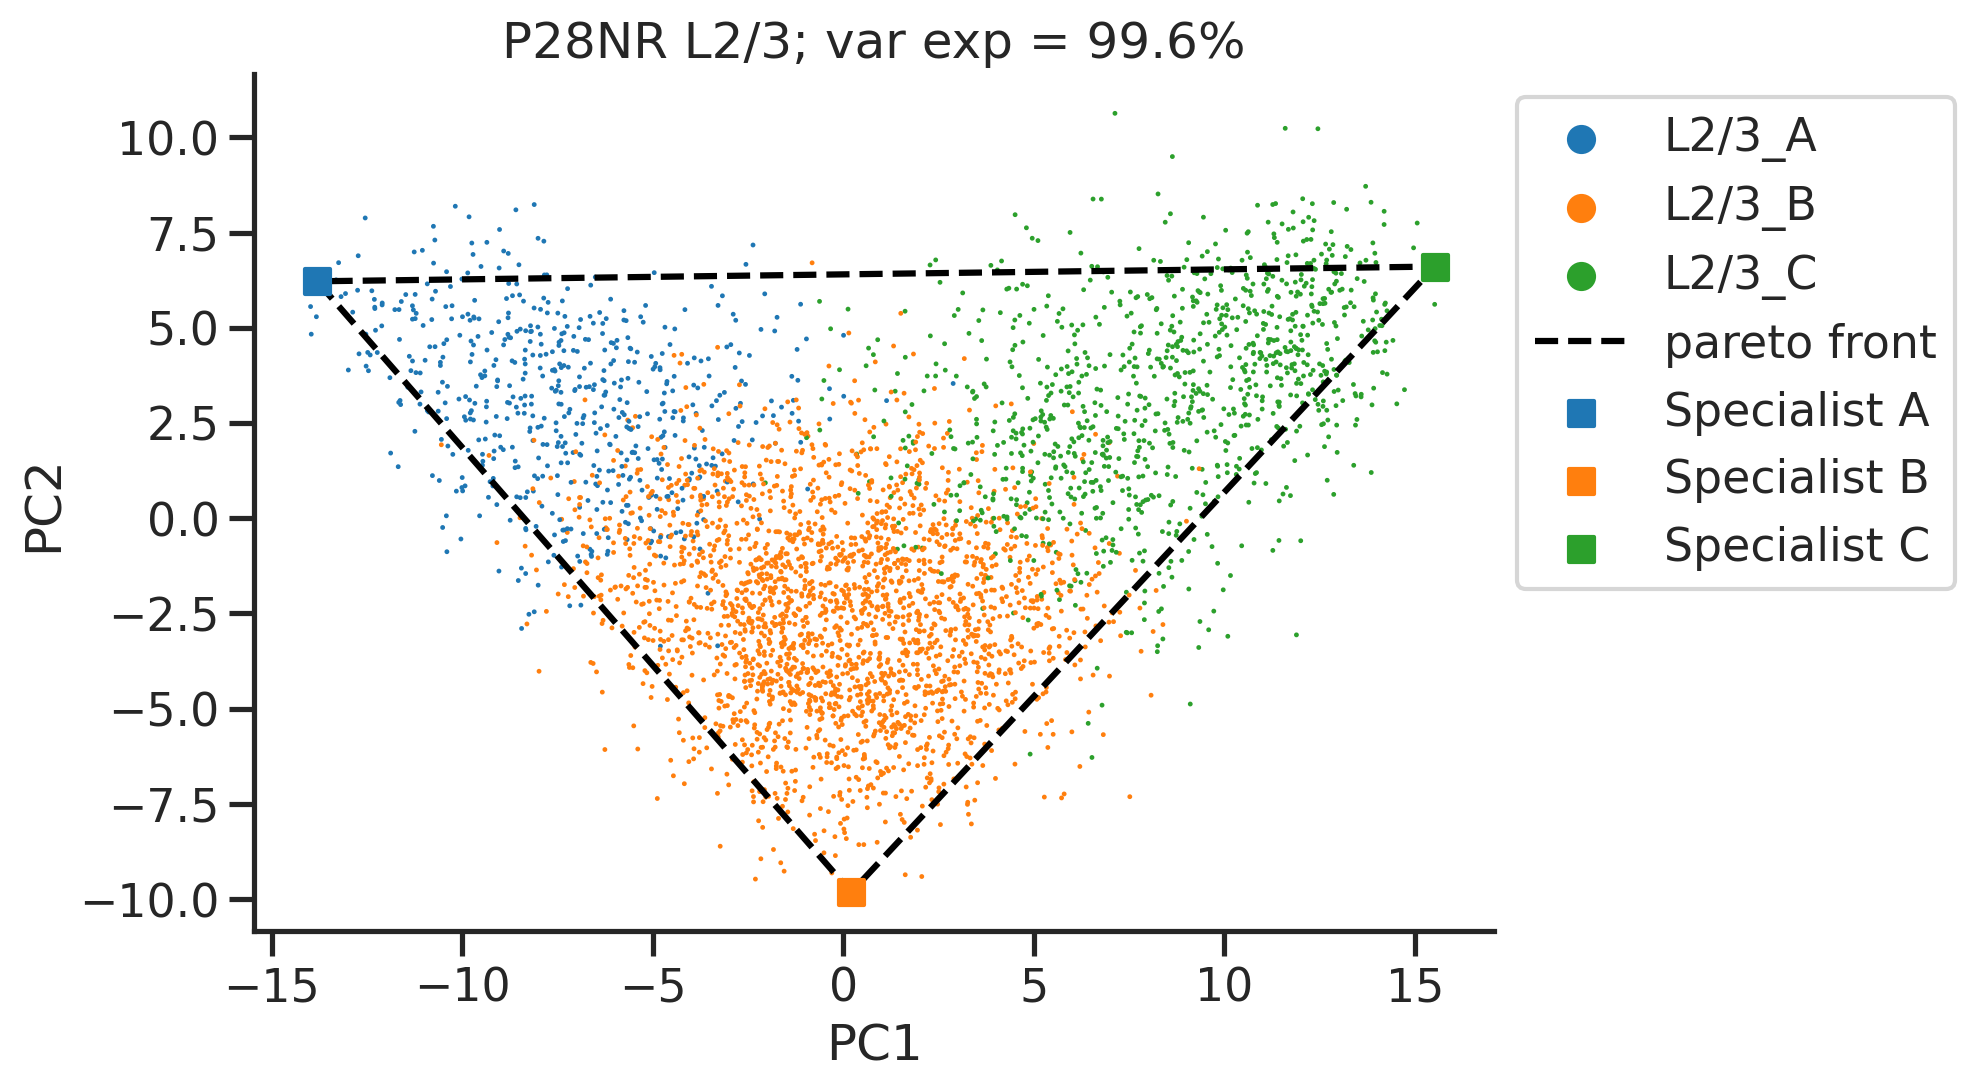

In [34]:
XC = XC_dict['P28NR']
df = df_nr28

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='easitype', s=3, palette=palette_type, hue_order=list(palette_type), edgecolor='none', ax=ax)
ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--k', label='pareto front', zorder=1)
ax.scatter(XC[0,[0]], XC[1,[0]], color='C0', marker='s', label='Specialist A')
ax.scatter(XC[0,[1]], XC[1,[1]], color='C1', marker='s', label='Specialist B')
ax.scatter(XC[0,[2]], XC[1,[2]], color='C2', marker='s', label='Specialist C')
ax.legend(bbox_to_anchor=(1,1))
ax.set_aspect('equal')
ax.set_title(f'P28NR L2/3; var exp = {100*varexpl:.1f}%')
output = os.path.join(outfigdir, 'grad_archetype.pdf')
powerplots.savefig_autodate(fig, output)
sns.despine(ax=ax)
ax.grid(False)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_archetype_2_2023-11-20.pdf


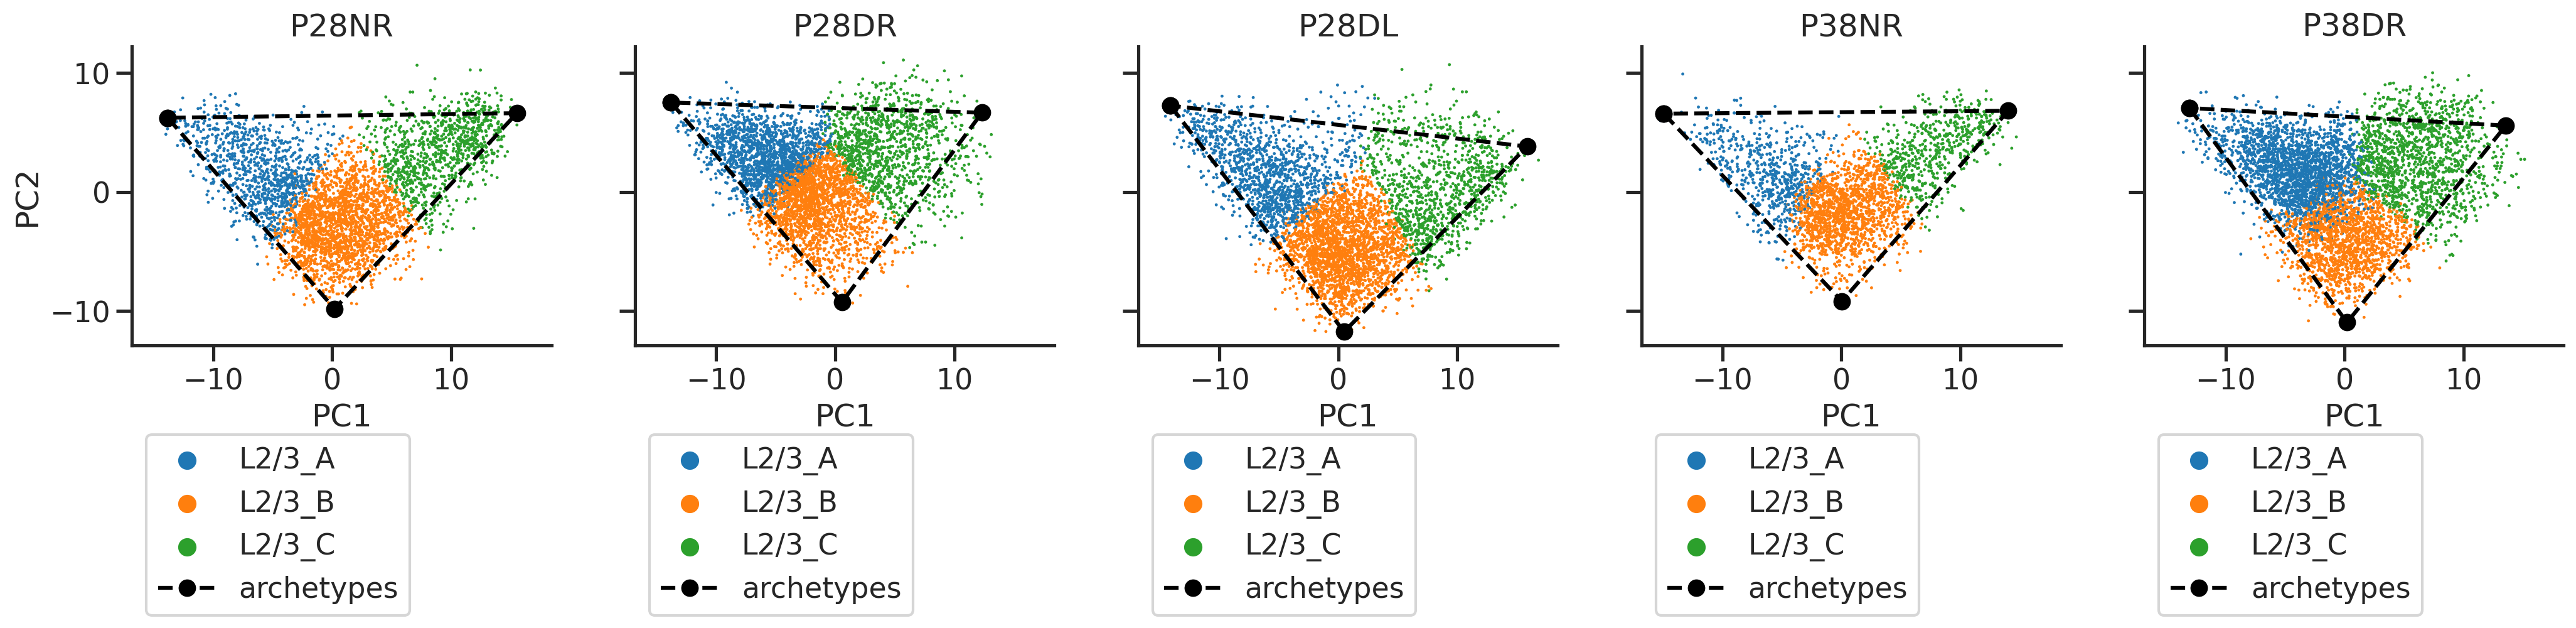

In [35]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    XC = XC_dict[lbl]
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), 
                    rasterized=True,
                    ax=ax)
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--ok', label='archetypes')
    ax.legend(bbox_to_anchor=(0,-0.25), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')
    ax.grid(False)
    sns.despine(ax=ax)

output = os.path.join(outfigdir, 'grad_archetype_2.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_archetype_4_2023-11-20.pdf


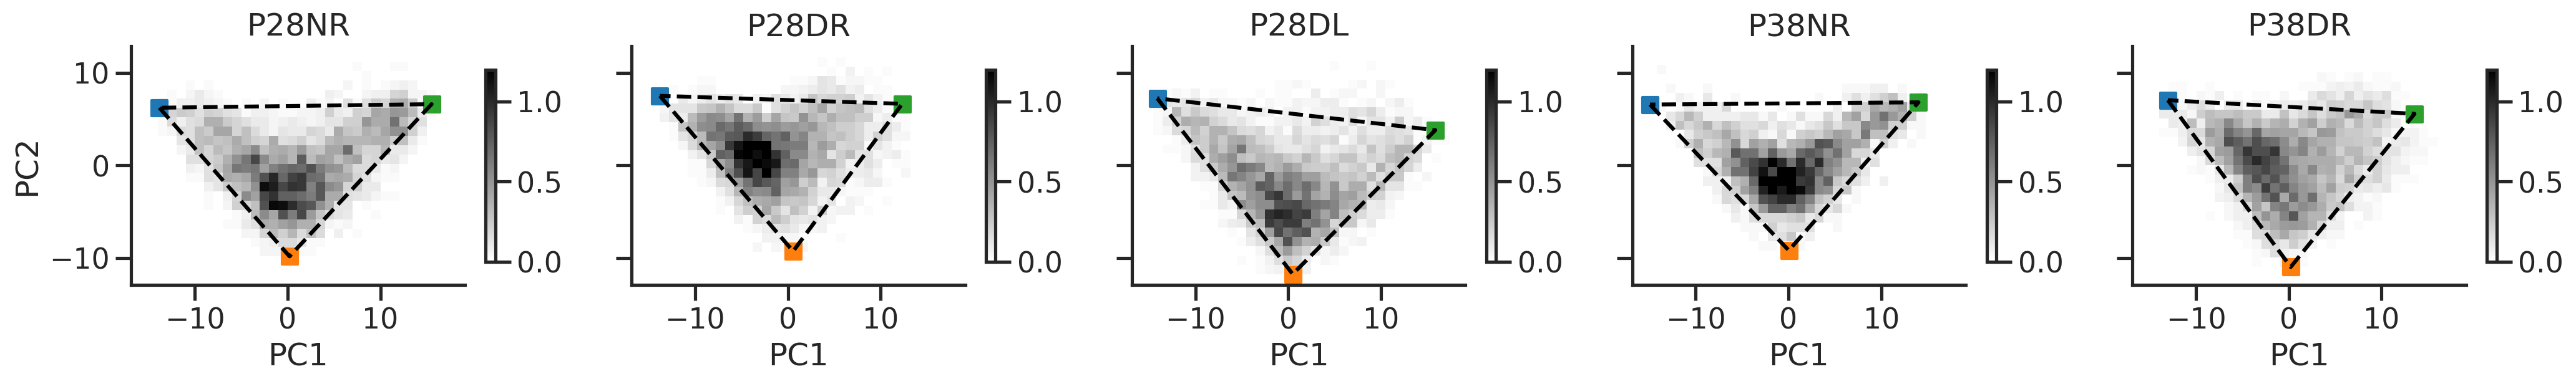

In [36]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    XC = XC_dict[lbl]
    g = sns.histplot(ax=ax, data=df, x='PC1', y='PC2', 
                 stat='percent', binwidth=1, vmin=0, vmax=1.2,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--k', label='archetypes')
    ax.scatter(XC[0,[0]], XC[1,[0]], color='C0', marker='s', label='Specialist A')
    ax.scatter(XC[0,[1]], XC[1,[1]], color='C1', marker='s', label='Specialist B')
    ax.scatter(XC[0,[2]], XC[1,[2]], color='C2', marker='s', label='Specialist C')
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl)
    ax.set_aspect('equal')
    
output = os.path.join(outfigdir, 'grad_archetype_4.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

In [37]:
bins = np.arange(-10, 10+2, 1)
hists = []
for df in dfs:
    a, _, _ = np.histogram2d(df['PC1'], df['PC2'], bins=bins)
    a = a/np.sum(a)*100
    hists.append(a)

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/diff_heatmap_2023-11-20.pdf


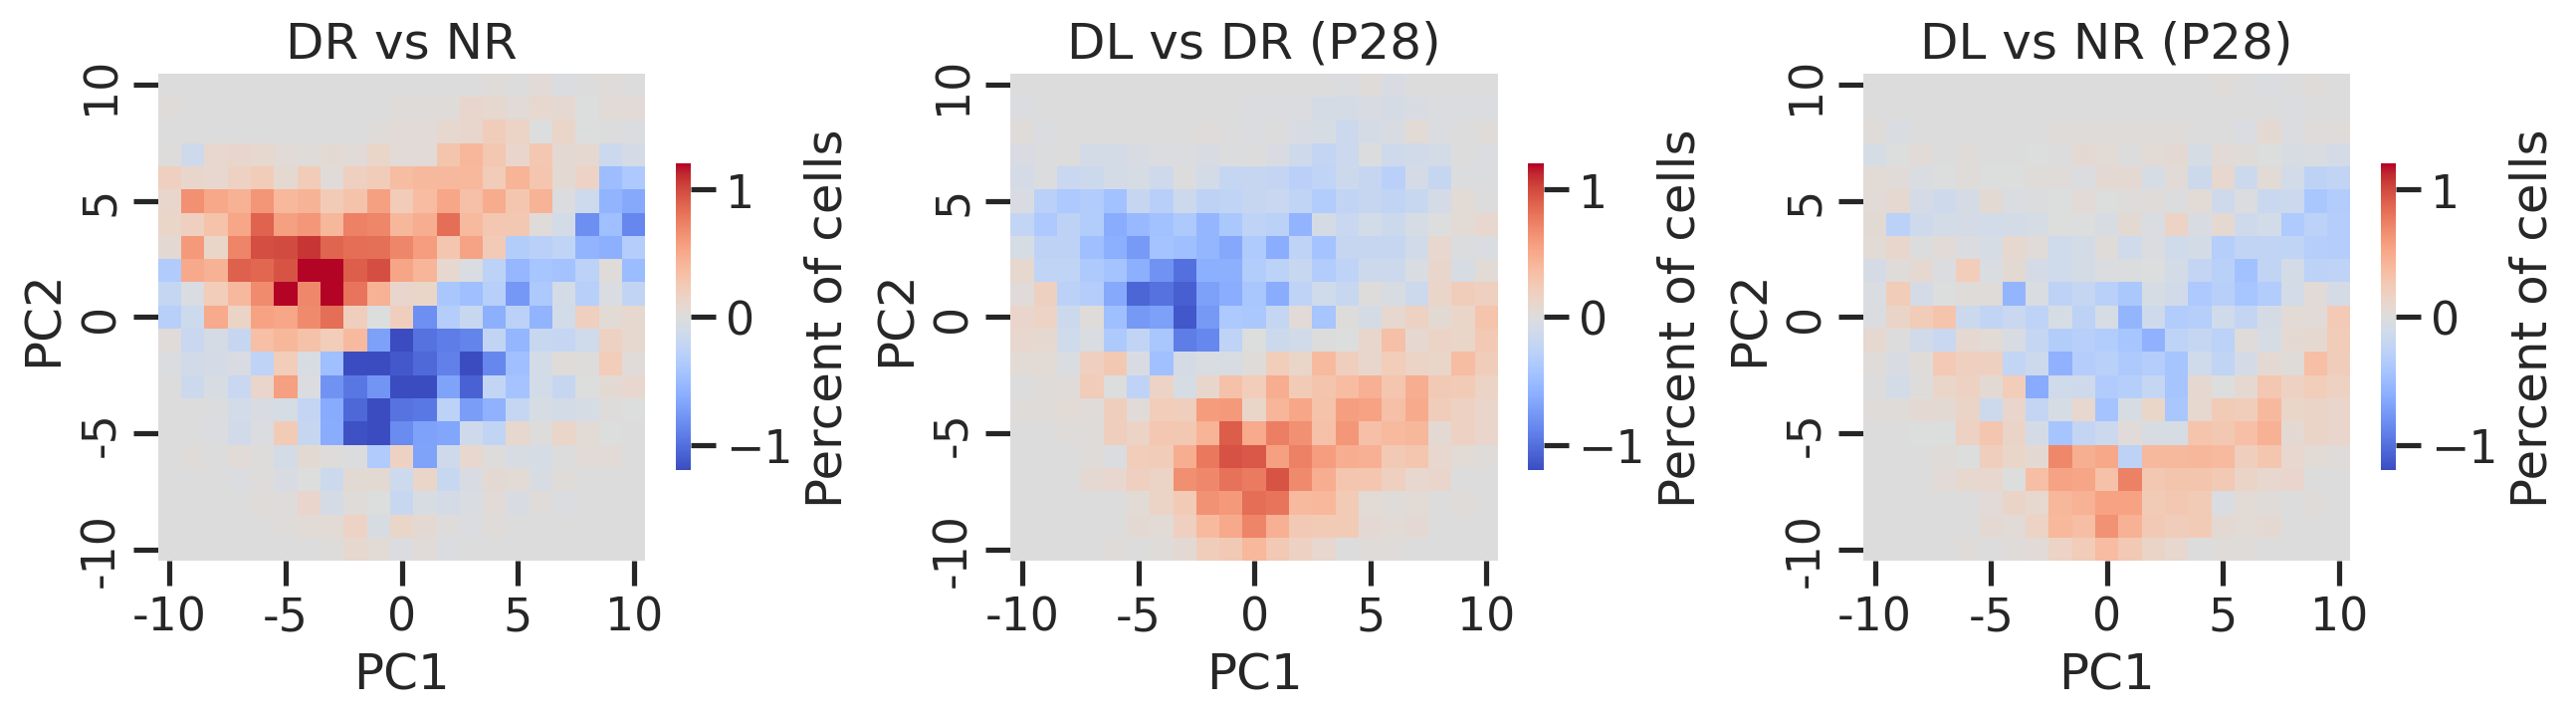

In [38]:
diff1 = pd.DataFrame((hists[1]+hists[4]-hists[0]-hists[3]).T, index=bins[:-1], columns=bins[:-1])
diff2 = pd.DataFrame((hists[2]-hists[1]).T, index=bins[:-1], columns=bins[:-1])
diff3 = pd.DataFrame((hists[2]-hists[0]).T, index=bins[:-1], columns=bins[:-1])
lbls = ['DR vs NR', 'DL vs DR (P28)', 'DL vs NR (P28)']
fig, axs = plt.subplots(1,3,figsize=(3*5,1*4))
for i, diff in enumerate([diff1, diff2, diff3]):
    ax = axs[i]
    lbl = lbls[i]
    sns.heatmap(diff, ax=ax, 
                xticklabels=5, yticklabels=5,
                vmax=1.2, vmin=-1.2, 
                rasterized=True,
                cmap='coolwarm', center=0, cbar_kws=dict(shrink=0.5, label='Percent of cells'))
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(lbl)
    
fig.subplots_adjust(wspace=0.4)
output = os.path.join(outfigdir, "diff_heatmap.pdf")
powerplots.savefig_autodate(fig, output)
plt.show()

# Optimal Transport

In [39]:
import ot
import ot.plot
from matplotlib import collections as mc

In [40]:
def OT_pipe(xs, xt, numbins=12):
    """
    xs = X_nr28.dot(V)[:,:2]
    xt = X_dr28.dot(V)[:,:2]
    """
    ns = len(xs)
    nt = len(xt)
    a = np.ones((ns,))/ns
    b = np.ones((nt,))/nt
    print(xs.shape, xt.shape)
    
    # ~5 sec for 4k cells vs 4k cells
    M = ot.dist(xs, xt)
    G0 = ot.emd(a, b, M)
    G0n = G0/np.array(G0.sum(axis=1)+1e-10).reshape(-1,1) #.shape
    
    # organize results (ns, nt)
    G0ns = sparse.coo_matrix(G0n)
    
    # per source cell vector
    alli, allj, allw = G0ns.row, G0ns.col, G0ns.data
    tmp = pd.DataFrame((xt[allj] - xs[alli])*allw.reshape(-1,1))
    tmp[2] = alli
    arrows = tmp.groupby(2).sum().reindex(np.arange(ns)).values
    
    # organize per cell vector 
    arrows = pd.DataFrame(arrows, columns=['dx', 'dy'])
    arrows['x'] = xs[:,0]
    arrows['y'] = xs[:,1]
    arrows['xbin'] = pd.cut(xs[:,0], numbins, labels=False)
    arrows['ybin'] = pd.cut(xs[:,1], numbins, labels=False)
    
    # local mean field
    n_arrows = arrows.groupby(['xbin', 'ybin']).size()
    n_arrows = n_arrows[n_arrows!=0]
    mean_arrows = arrows.groupby(['xbin', 'ybin']).mean().reindex(n_arrows.index).fillna(0) #.dropna()
    
    mags = np.sqrt(arrows['dx']**2+arrows['dy']**2)  # n_arrows # [[2,3]] #*n_arrows
    mean_mags = np.mean(mags)
    
    return G0ns, arrows, n_arrows, mean_arrows, mean_mags
    

In [41]:
def OT_plot(n_arrows, mean_arrows, XC, output=None):
    """
    """
    maxsize = np.max(n_arrows)
    minsize = np.min(n_arrows)
    print(minsize, maxsize)

    fig, ax = plt.subplots(figsize=(7,5))
    for size, arrow in zip(n_arrows.values, mean_arrows[['x', 'y', 'dx', 'dy']].values):
        ax.arrow(*arrow, linewidth=1, width=0.2, alpha=size/maxsize, edgecolor='none', facecolor='k')

    ax.scatter(XC[0,[0]], XC[1,[0]], color='C0', marker='s', label='Specialist A')
    ax.scatter(XC[0,[1]], XC[1,[1]], color='C1', marker='s', label='Specialist B')
    ax.scatter(XC[0,[2]], XC[1,[2]], color='C2', marker='s', label='Specialist C')
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--k', label='pareto front')
    ax.grid(False)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1,1))
    if output:
        powerplots.savefig_autodate(fig, output)
    plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_archetype_5_2023-11-20.pdf


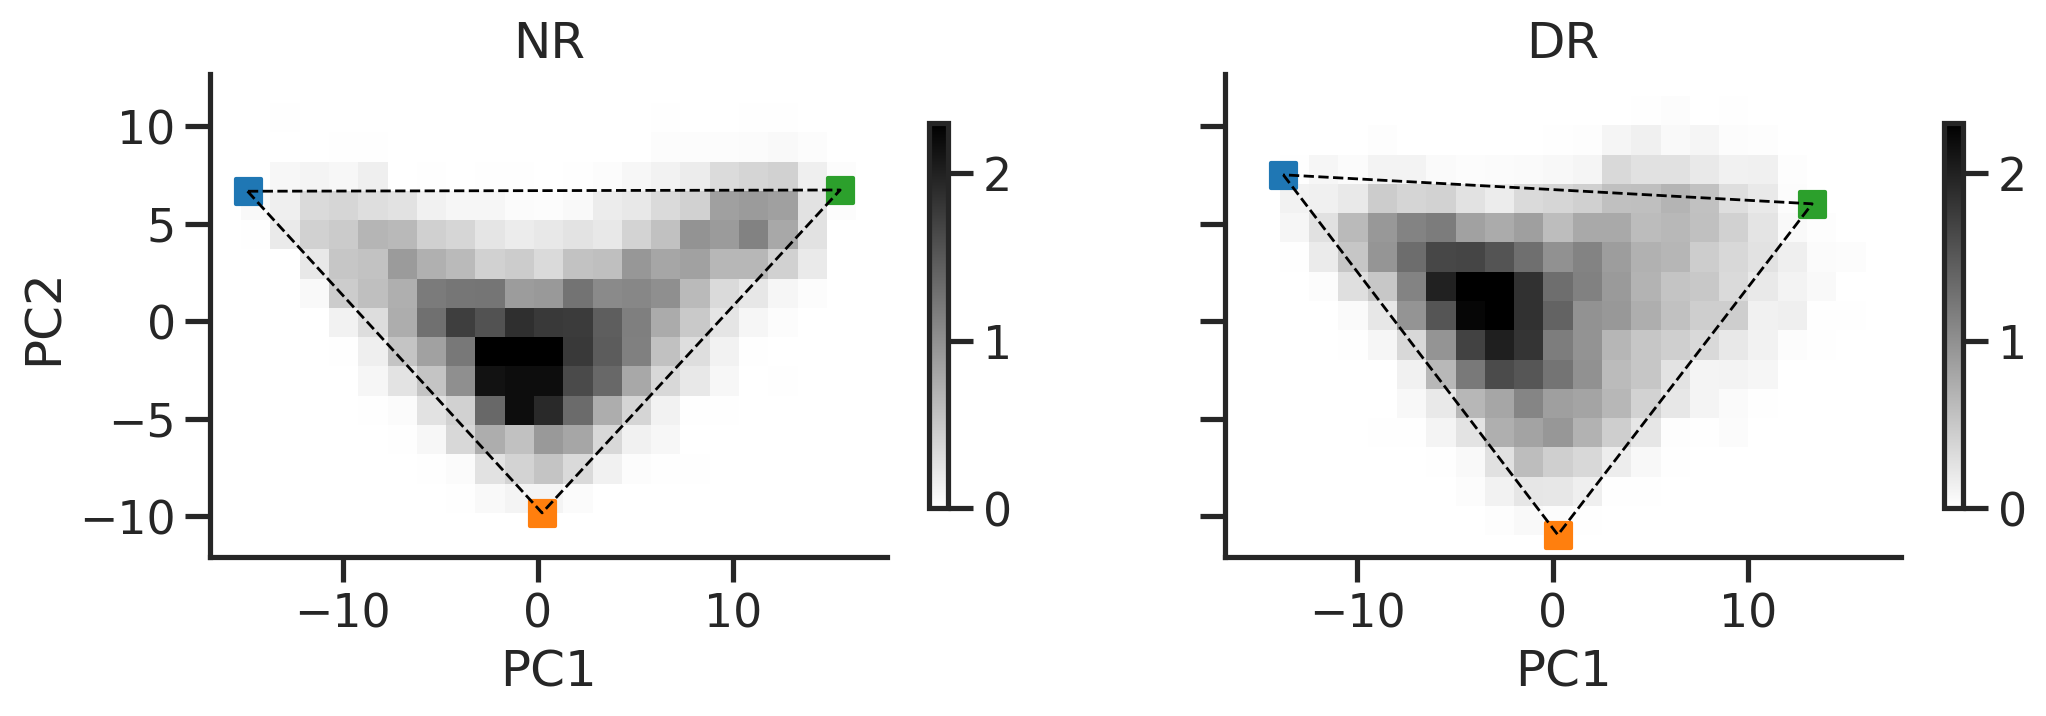

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(2*6,1*5), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs2, labels2):
    XC = XC_dict2[lbl]
    g = sns.histplot(ax=ax, data=df, x='PC1', y='PC2', 
                 stat='percent', binwidth=1.5, vmin=0, vmax=2.3,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--', label='archetypes', color='k', linewidth=1)
    ax.scatter(XC[0,[0]], XC[1,[0]], color='C0', marker='s', label='Specialist A')
    ax.scatter(XC[0,[1]], XC[1,[1]], color='C1', marker='s', label='Specialist B')
    ax.scatter(XC[0,[2]], XC[1,[2]], color='C2', marker='s', label='Specialist C')
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl)
    ax.set_aspect('equal')
    
output = os.path.join(outfigdir, 'grad_archetype_5.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

In [43]:
ot_res = dict()
XC = XC_dict['P28NR']

In [44]:
xs = prj_nr # adata[adata.obs['cond'].isin(['P28NR', 'P38NR'])].obsm['pcs'][:,:2]
xt = prj_dr # adata[adata.obs['cond'].isin(['P28DR', 'P38DR'])].obsm['pcs'][:,:2]

In [45]:
_, _, n_arrows, mean_arrows, mean_mags = OT_pipe(xs, xt, numbins=15)
ot_res['NR vs DR'] = (n_arrows, mean_arrows, mean_mags)

(6741, 2) (9869, 2)


/u/home/f/f7xiesnm/.conda/envs/napari/lib/python3.9/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


1 227
saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/ot_nrdr_2023-11-20.pdf


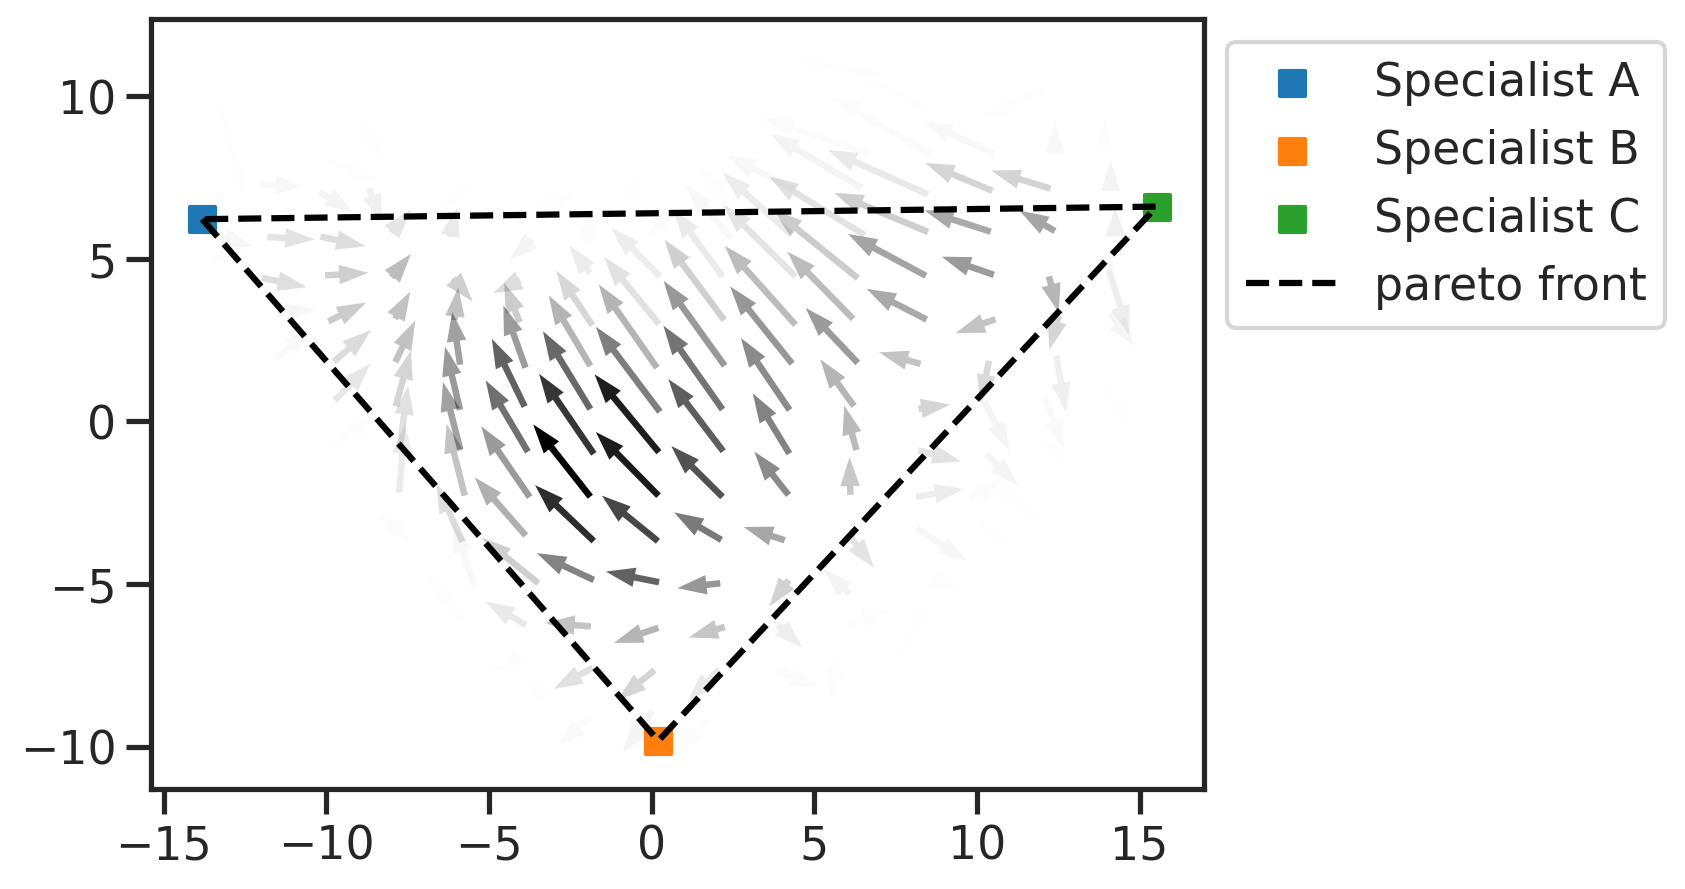

In [46]:
output = os.path.join(outfigdir, 'ot_nrdr.pdf')
OT_plot(n_arrows, mean_arrows, XC, 
        output=output, 
       )

# quantify A, B, C closeness

In [47]:
res_frac = pd.DataFrame(index=['A pole', 'B pole', 'C pole'])

for lbl in labels:
    unqs, cnts = np.unique(np.argmin(dists_dict[lbl], axis=0), return_counts=True)
    print(unqs, cnts/cnts.sum())
    res_frac[lbl] = cnts/cnts.sum()

[0 1 2] [0.17631058 0.59619189 0.22749753]
[0 1 2] [0.32142857 0.46215986 0.21641156]
[0 1 2] [0.20240395 0.60957287 0.18802318]
[0 1 2] [0.13199852 0.65072303 0.21727846]
[0 1 2] [0.28983543 0.45053243 0.25963214]


saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/bar_frac_abc_pole_2023-11-20.pdf


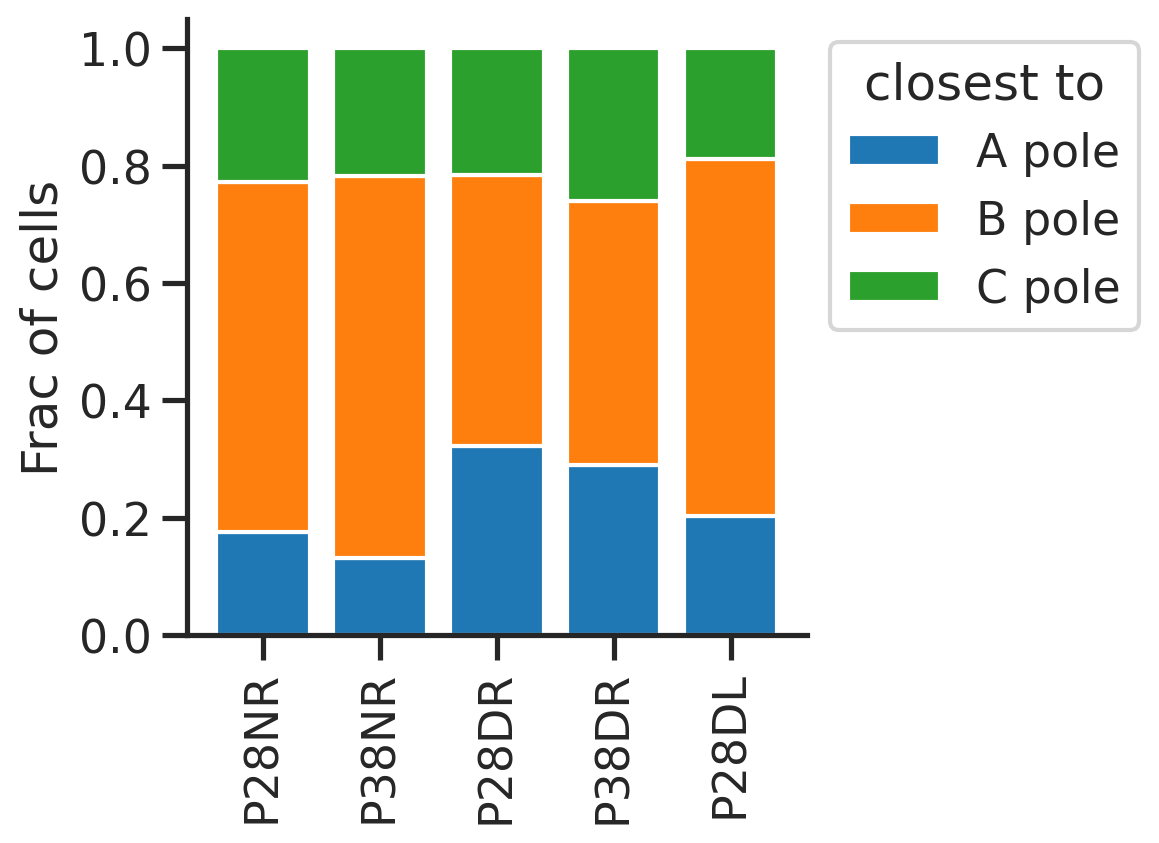

In [48]:
fig, ax = plt.subplots(figsize=(4,4))
res_frac[['P28NR', 'P38NR', 'P28DR', 'P38DR', 'P28DL']].T.plot.bar(
    ax=ax, stacked=True, width=0.8,  
)
ax.legend(bbox_to_anchor=(1,1), title='closest to')
sns.despine(ax=ax)
ax.set_ylabel('Frac of cells')
ax.grid(False)
output = os.path.join(outfigdir, 'bar_frac_abc_pole.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()


In [49]:
dfbox = res_frac.stack().reset_index()
dfbox['cond'] = dfbox['level_1'].apply(lambda x: x[3:])
dfbox

level_0 level_1         0 cond
0   A pole   P28NR  0.176311   NR
1   A pole   P28DR  0.321429   DR
2   A pole   P28DL  0.202404   DL
3   A pole   P38NR  0.131999   NR
4   A pole   P38DR  0.289835   DR
5   B pole   P28NR  0.596192   NR
6   B pole   P28DR  0.462160   DR
7   B pole   P28DL  0.609573   DL
8   B pole   P38NR  0.650723   NR
9   B pole   P38DR  0.450532   DR
10  C pole   P28NR  0.227498   NR
11  C pole   P28DR  0.216412   DR
12  C pole   P28DL  0.188023   DL
13  C pole   P38NR  0.217278   NR
14  C pole   P38DR  0.259632   DR

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/box_abc_poles_2023-11-20.pdf


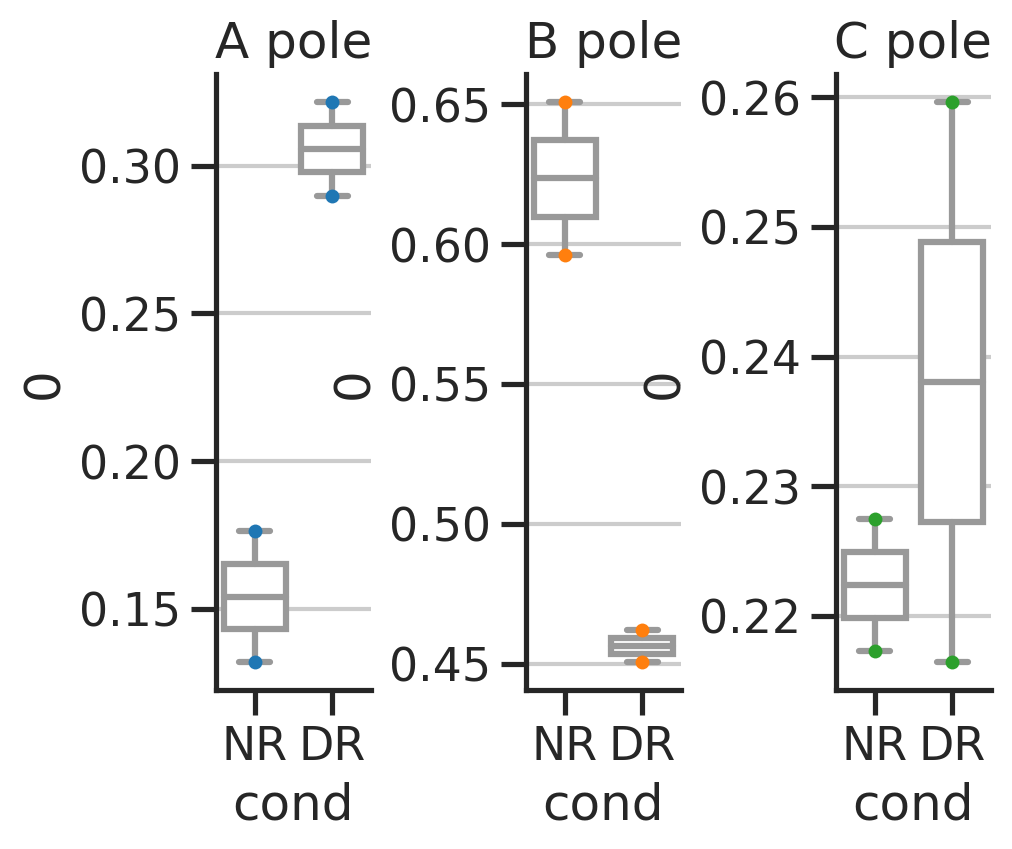

In [50]:
fig, axs = plt.subplots(1,3, figsize=(5,4))
ax = axs[0]
dfboxsub = dfbox[(dfbox['cond'].isin(['NR', 'DR'])) & (dfbox['level_0']=='A pole')]
sns.boxplot(data=dfboxsub, x='cond', y=0, color='white', ax=ax)
sns.swarmplot(data=dfboxsub, x='cond', y=0, ax=ax, color='C0')
ax.set_title('A pole')
sns.despine(ax=ax)

ax = axs[1]
dfboxsub = dfbox[(dfbox['cond'].isin(['NR', 'DR'])) & (dfbox['level_0']=='B pole')]
sns.boxplot(data=dfboxsub, x='cond', y=0, color='white', ax=ax)
sns.swarmplot(data=dfboxsub, x='cond', y=0, ax=ax, color='C1')
ax.set_title('B pole')
sns.despine(ax=ax)

ax = axs[2]
dfboxsub = dfbox[(dfbox['cond'].isin(['NR', 'DR'])) & (dfbox['level_0']=='C pole')]
sns.boxplot(data=dfboxsub, x='cond', y=0, color='white', ax=ax)
sns.swarmplot(data=dfboxsub, x='cond', y=0, ax=ax, color='C2')
ax.set_title('C pole')
sns.despine(ax=ax)
fig.subplots_adjust(wspace=1)

output = os.path.join(outfigdir, "box_abc_poles.pdf")
powerplots.savefig_autodate(fig, output)
plt.show()


# quantify distance to A, B

In [51]:
def plot_dists(idx, xlim=None, ylim=None):
    bins = np.arange(0,30,0.5) #linspace(0,30,30)

    fig, ax = plt.subplots()
    sns.histplot(dists_dict['P28NR'][idx], ax=ax, stat='percent', element='step', cumulative=True, fill=False, bins=bins, 
                 label='P28NR', color='k')
    sns.histplot(dists_dict['P28DR'][idx], ax=ax, stat='percent', element='step', cumulative=True, fill=False, bins=bins, 
                 label='P28DR', color='C1')
    sns.histplot(dists_dict['P28DL'][idx], ax=ax, stat='percent', element='step', cumulative=True, fill=False, bins=bins, 
                 label='P28DL', color='gray')

    sns.histplot(dists_dict['P38NR'][idx], ax=ax, stat='percent', element='step', cumulative=True, fill=False, bins=bins, 
                 label='P38NR', color='k',  linestyle='dotted')
    sns.histplot(dists_dict['P38DR'][idx], ax=ax, stat='percent', element='step', cumulative=True, fill=False, bins=bins, 
                 label='P38DR', color='C1', linestyle='dotted')
    ax.legend(bbox_to_anchor=(1,1))
    ax.grid(False)
    sns.despine(ax=ax)
    if xlim: 
        ax.set_xlim(xlim)
    if ylim: 
        ax.set_ylim(ylim)
    return fig, ax


In [52]:
for lbl in labels:
    print(dists_dict[lbl].max())

29.545753450587334
27.47245113905372
31.258050734180856
29.68181404950856
28.483994052291553


saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/cumdist_a_2023-11-20.pdf


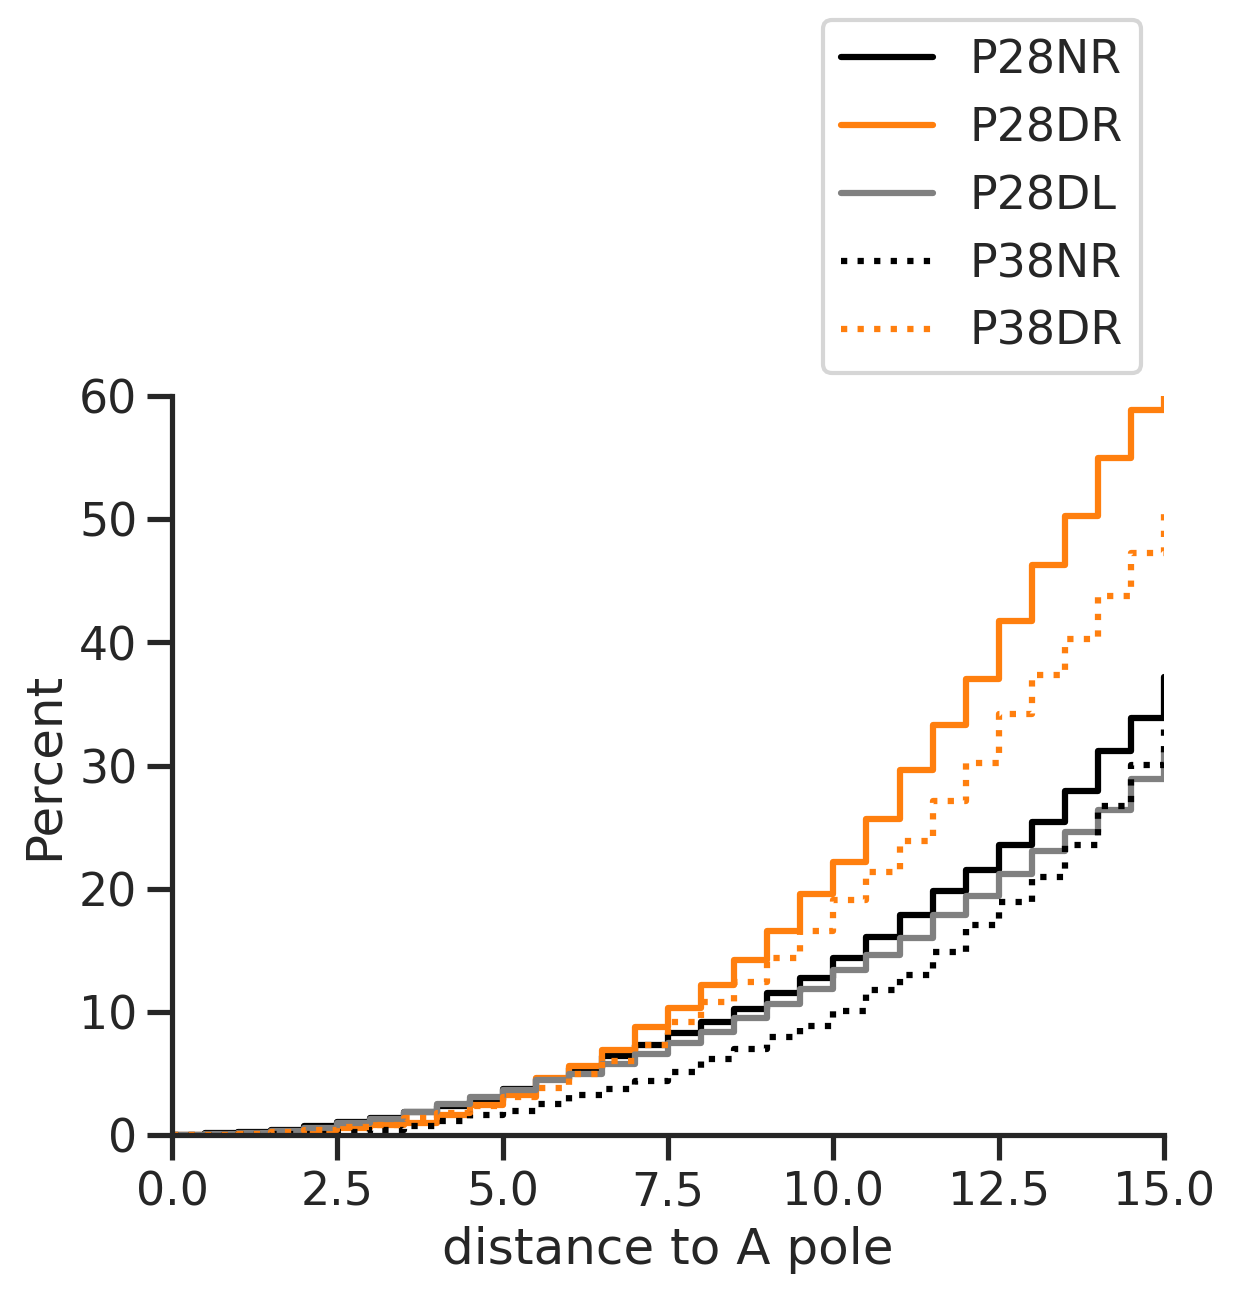

In [53]:
fig, ax = plot_dists(0, xlim=[0,15], ylim=[0,60])
ax.set_xlabel('distance to A pole')
output = os.path.join(outfigdir, 'cumdist_a.pdf')
powerplots.savefig_autodate(fig, output)

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/cumdist_b_2023-11-20.pdf


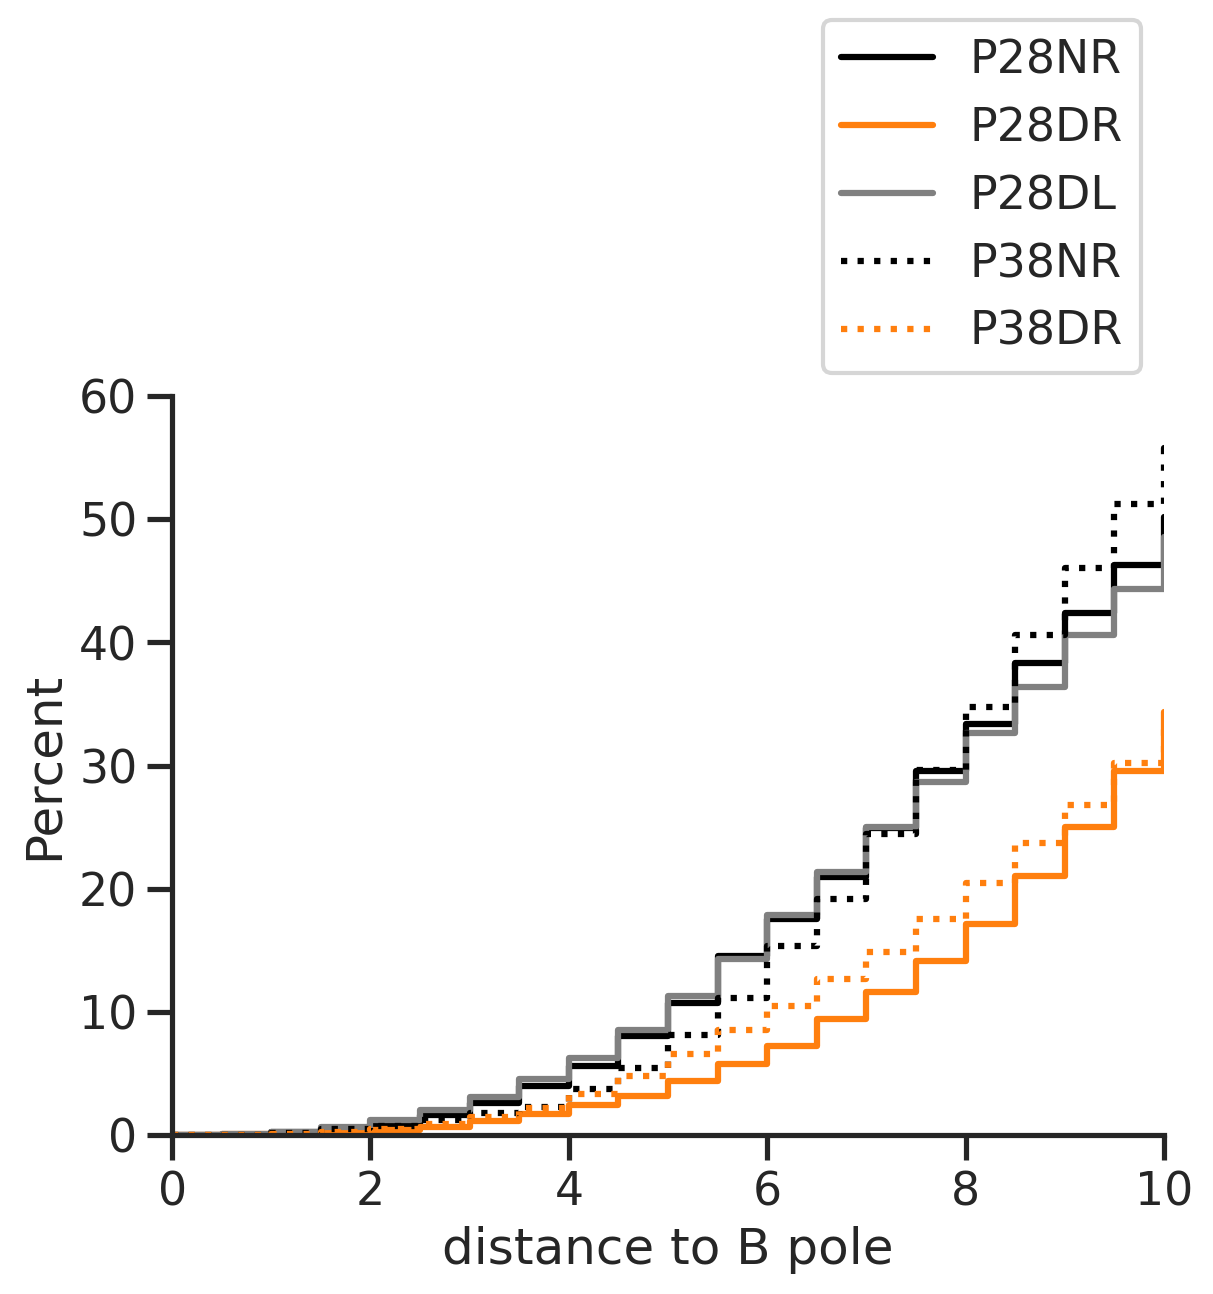

In [54]:
fig, ax = plot_dists(1, xlim=[0,10], ylim=[0,60])
ax.set_xlabel('distance to B pole')
output = os.path.join(outfigdir, 'cumdist_b.pdf')
powerplots.savefig_autodate(fig, output)

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/cumdist_c_2023-11-20.pdf


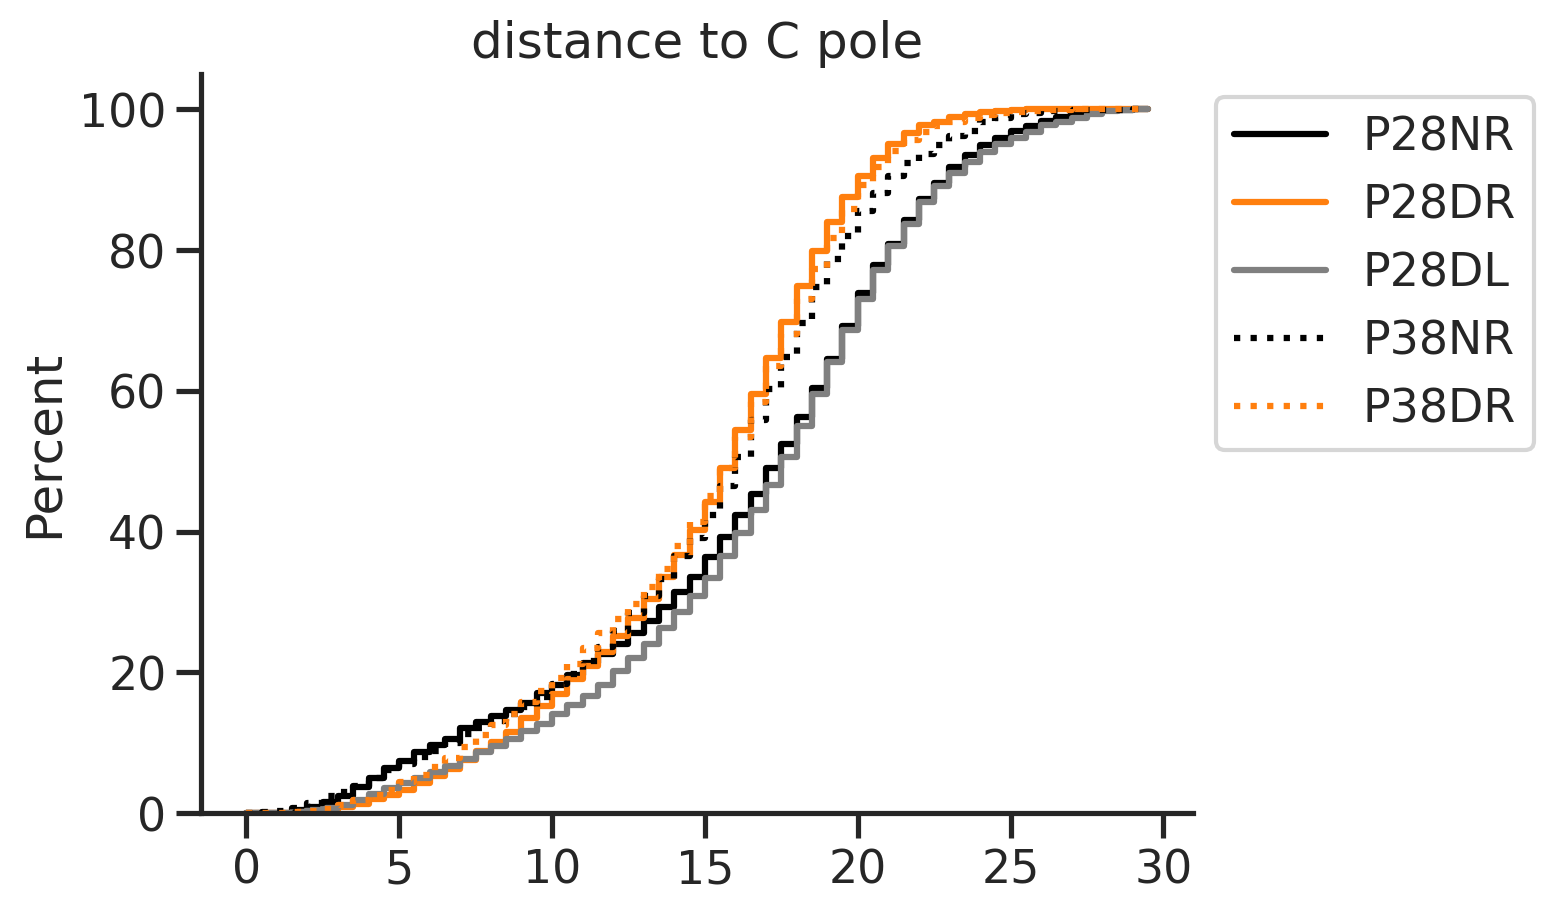

In [55]:
fig, ax = plot_dists(2)
ax.set_title('distance to C pole')
output = os.path.join(outfigdir, 'cumdist_c.pdf')
powerplots.savefig_autodate(fig, output)

# Quantify JS distance

In [56]:
from scipy.spatial.distance import jensenshannon

In [57]:
from scipy.cluster import hierarchy as sch

In [58]:
bins = np.arange(-15, 15+2, 1)
hists = []
for df in dfs:
    a, _, _ = np.histogram2d(df['PC1'], df['PC2'], bins=bins)
    a = a/np.sum(a)*100
    hists.append(a)

In [59]:
res_js = np.zeros((5,5))
js_min = 1
for i in np.arange(5):
    for j in np.arange(5):
        if j > i:
            p = np.ravel(hists[i])
            q = np.ravel(hists[j])
            p = p/np.sum(p)
            q = q/np.sum(q)
            js = jensenshannon(p, q) 
            
            res_js[i,j] = js
            res_js[j,i] = js
            js_min = min(js, js_min)

In [60]:
# order = [2,0,3,1,4]
order, Z = basicu.order_by_hc(res_js, return_Z=True) # [::-1]
# np.array(labels)[order]

/u/project/zipursky/f7xiesnm/code/scroutines/scroutines/basicu.py:437: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(X, method=method)


In [61]:
print(np.max(res_js), np.min(res_js))
# print(np.percentile(res_js, 90))
# print(np.percentile(res_js, 80))
print(np.percentile(res_js, 75))
print(np.percentile(res_js, 25))
print(js_min)

0.4144020293102614 0.0
0.33611872571938084
0.22344018189811987
0.22344018189811987


saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/js_heatmap_2023-11-20.pdf


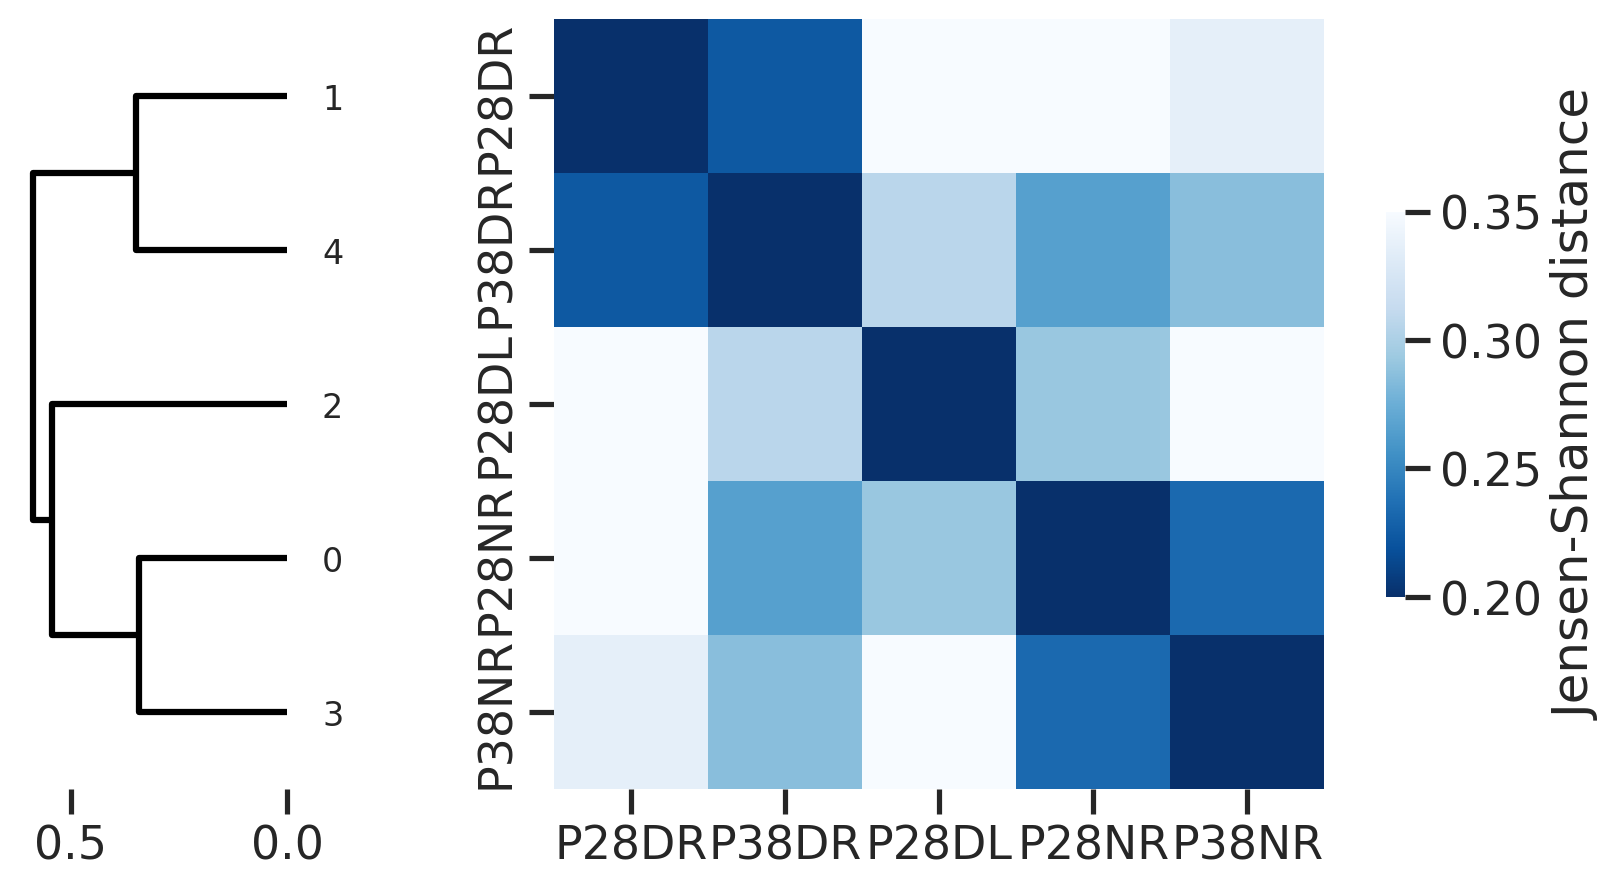

In [62]:
fig, axs = plt.subplot_mosaic("ABBBB", figsize=(10,5))

ax = axs['A']
d = sch.dendrogram(Z, ax=ax, orientation='left', above_threshold_color='k', color_threshold=0)
ax.invert_yaxis()
sns.despine(ax=ax, left=True, bottom=True)
ax.grid(False)

ax = axs['B']
sns.heatmap(pd.DataFrame(res_js).reindex(order)[order], #[order][:,order], 
            cmap='Blues_r', 
            # vmin=js_min, vmax=0.4,
            # vmin=js_min,
            vmin=0.2,
            vmax=0.35,
            cbar_kws=dict(shrink=0.5, ticks=[0.2, 0.25, 0.3, 0.35], label='Jensen-Shannon distance'),
            xticklabels=np.array(labels)[order],
            yticklabels=np.array(labels)[order],
            ax=ax,
           )
ax.set_aspect('equal')
output = os.path.join(outfigdir, "js_heatmap.pdf")
powerplots.savefig_autodate(fig, output)

# Quantify JS distance v2 (NR DR only)

In [63]:
dfs3 = dfs[:2] + dfs[3:]
labels3 = labels[:2] + labels[3:]
labels3

['P28NR', 'P28DR', 'P38NR', 'P38DR']

In [64]:
bins = np.arange(-15, 15+2, 1)
hists3 = []
for df in dfs3:
    a, _, _ = np.histogram2d(df['PC1'], df['PC2'], bins=bins)
    a = a/np.sum(a)*100
    hists3.append(a)

In [65]:
res_js3 = np.zeros((4,4))
js_min = 1
for i in np.arange(4):
    for j in np.arange(4):
        if j > i:
            p = np.ravel(hists3[i])
            q = np.ravel(hists3[j])
            p = p/np.sum(p)
            q = q/np.sum(q)
            js = jensenshannon(p, q) 
            
            res_js3[i,j] = js
            res_js3[j,i] = js
            js_min = min(js, js_min)

In [66]:
# order = [2,0,3,1,4]
order3, Z3 = basicu.order_by_hc(res_js3, return_Z=True) # [::-1]
# np.array(labels)[order]

/u/project/zipursky/f7xiesnm/code/scroutines/scroutines/basicu.py:437: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(X, method=method)


In [67]:
js_min

0.22344018189811987

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/js_heatmap_nrdr_only_2023-11-20.pdf


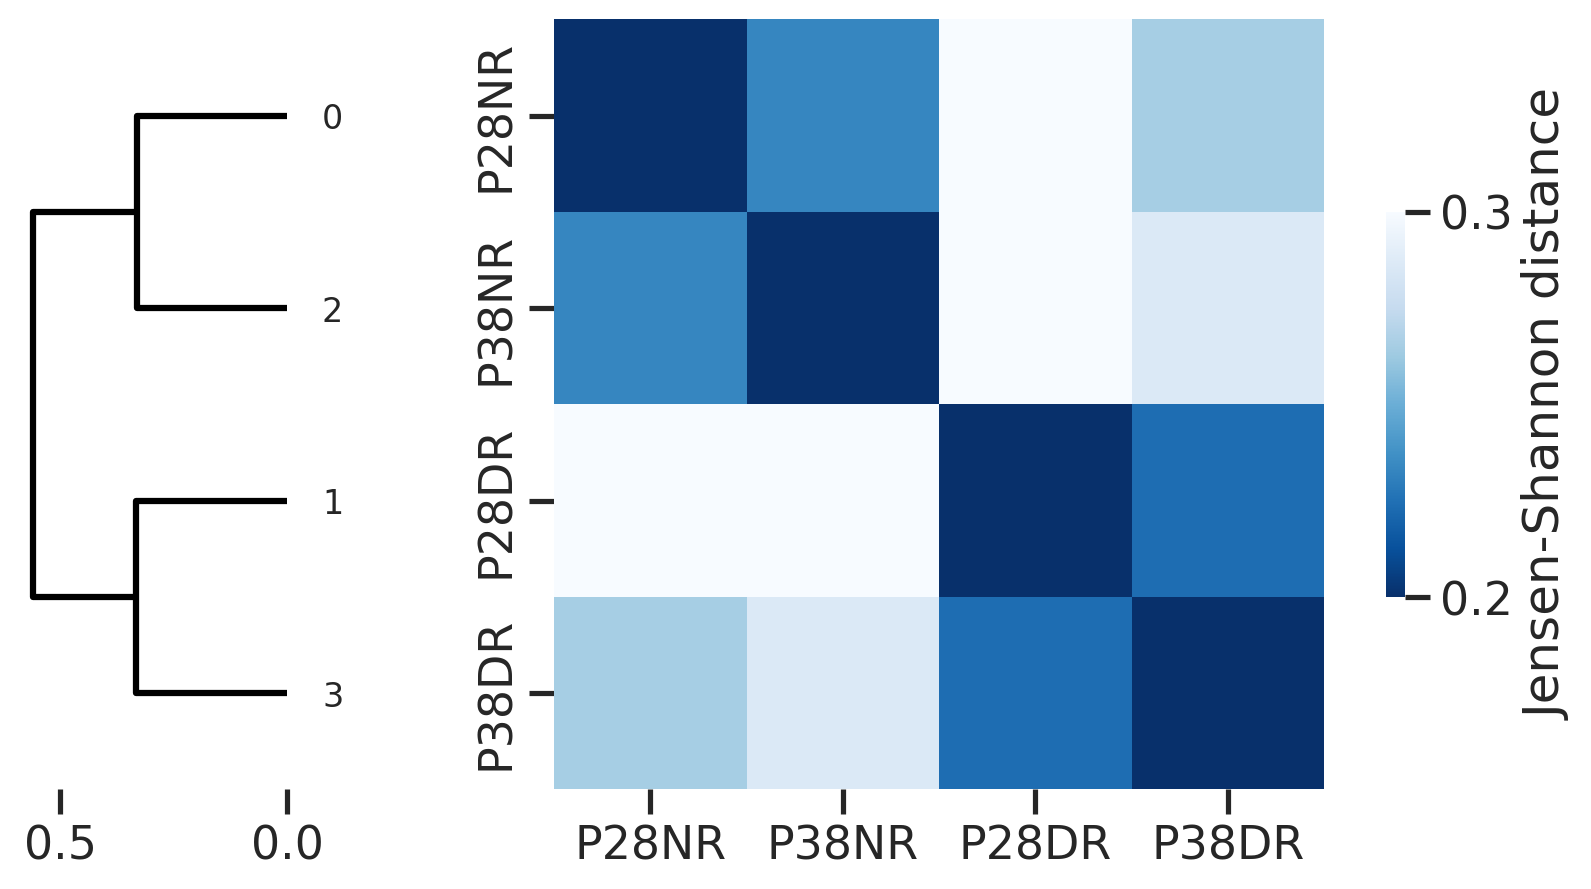

In [68]:
fig, axs = plt.subplot_mosaic("ABBBB", figsize=(10,5))

ax = axs['A']
d = sch.dendrogram(Z3, ax=ax, orientation='left', above_threshold_color='k', color_threshold=0)
sns.despine(ax=ax, left=True, bottom=True)
ax.invert_yaxis()
ax.grid(False)

ax = axs['B']
sns.heatmap(pd.DataFrame(res_js3).reindex(order3)[order3], cmap='Blues_r', 
            # vmin=js_min, vmax=0.4,
            # vmin=js_min,
            vmin=0.2,
            vmax=0.3,
            cbar_kws=dict(shrink=0.5, ticks=[0.2, 0.3], label='Jensen-Shannon distance'),
            xticklabels=np.array(labels3)[order3],
            yticklabels=np.array(labels3)[order3],
            ax=ax,
           )
ax.set_aspect('equal')
output = os.path.join(outfigdir, "js_heatmap_nrdr_only.pdf")
powerplots.savefig_autodate(fig, output)